# Машинное обучение, ФКН ВШЭ

# Практическое задание 12. Несбалансированные задачи

## Общая информация
Дата выдачи: 01.05.2022

Мягкий дедлайн: 11.05.2022 23:59 MSK

Жёсткий дедлайн: 16.05.2022 23:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-xx-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

## О задании

В этом задании мы разберем основные техники работы в задачах, где один из классов занимает существенно меньшую долю выборки, чем остальные. Для простоты мы обойдемся бинарной задачей, тем не менее, во многом данные методы можно перенести и на задачи с б**о**льшим числом классов. Кроме того, вы получите очередной бесценный опыт исследования случайной библиотеки случайных индусов с нуля.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from tqdm.auto import tqdm

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Задание -1 (1 балл)**. EDA

В качестве данных для нашей работы возьмем выложенный на kaggle датасет транзакций, в котором нужно выискивать мошеннические проводки: [клик](https://www.kaggle.com/mlg-ulb/creditcardfraud). Данная задача по определению подходит под несбалансированную, что можно сказать даже без наличия каких-либо данных (понятно, что среди всех транзакций клиентов очень малая часть будет мошеннической).

Загрузим данные, проведем некоторые классические манипуляции.

In [ ]:
"""%%bash
kaggle datasets download -d mlg-ulb/creditcardfraud
unzip creditcardfraud.zip""";

In [3]:
df = pd.read_csv('/content/drive/My Drive/creditcard.csv') # to open in colab
# df = pd.read_csv('creditcard.csv')

In [4]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


Наши данные были анонимизированы. Мы имеем 30 признаков, из которых 28 - это результаты PCA-преобразования на исходном датасете. Еще 2 признака представляют собой время в секундах, прошедшее с момента первой транзакции в датасете, и размер транзакции. Скажите, какова доля положительных объектов в выборке?

In [5]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [6]:
print('Доля положительных объектов:', (df[df['Class'] == 1].shape[0]) / (df.shape[0]))

Доля положительных объектов: 0.001727485630620034


:))

Начнем с обработки времени. Секунды сами по себе не несут большой информации о зависимостях в данных, попробуйте по ним создать признаки "час" (от 0 до 23) и "день" (от 0 до ...) в аналогичной манере (принимая первый объект выборки за начальную точку). Сколько дней покрывают данные?

In [7]:
hour = df['Time'] // 3600 % 24
day = df['Time'] // 86400

df['Hour'] = hour
df['Day'] = day

df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Hour,Day
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.0,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.0,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0.0,0.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.0,0.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0,23.0,1.0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0,23.0,1.0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0,23.0,1.0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0,23.0,1.0


Данные покрывают два дня.

In [8]:
# just checkin
df['Hour'].value_counts()

21.0    17703
18.0    17039
11.0    16856
20.0    16756
10.0    16598
14.0    16570
15.0    16461
16.0    16453
17.0    16166
9.0     15838
19.0    15649
22.0    15441
12.0    15420
13.0    15365
23.0    10938
8.0     10276
0.0      7695
7.0      7243
1.0      4220
6.0      4101
3.0      3492
2.0      3328
5.0      2990
4.0      2209
Name: Hour, dtype: int64

Постройте следующие графики:

1. Распределение числа транзакций по каждому часу (line-plot).
2. Распределение доли мошеннических транзакций по каждому часу (line-plot)
3. То же самое для дней (здесь можно использовать bar-plot, так как дней должно быть немного).

Какие выводы можно сделать из графиков? На ваш взгляд, как можно связать полученные нами часы с реальными часами в сутках?

In [9]:
fraud = df[df['Class']==1]

hours = df['Hour'].value_counts().sort_index().keys()
values = df['Hour'].value_counts().sort_index()
fraud_counts = fraud['Hour'].value_counts().sort_index()
fraud_pc = fraud['Hour'].value_counts().sort_index() / df['Hour'].value_counts().sort_index()

data = pd.DataFrame({'Hour': hours, 'Transactions': values,'Fraud transactions': fraud_counts, '% Fraud transactions': fraud_pc})
data.head()

,Hour,Transactions,Fraud transactions,% Fraud transactions
0.0,0.0,7695,6,0.000780
1.0,1.0,4220,10,0.002370
2.0,2.0,3328,57,0.017127
3.0,3.0,3492,17,0.004868
4.0,4.0,2209,23,0.010412


Text(0.5, 1.0, 'Распределение доли мошеннических транзакций по каждому часу')

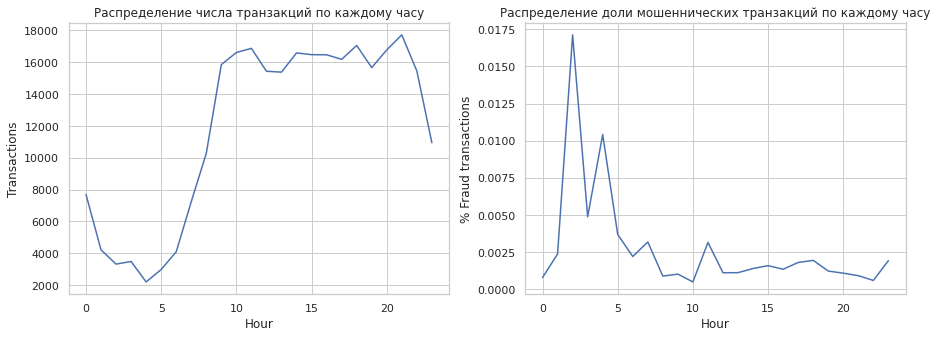

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.lineplot(ax=axes[0], data=data, x='Hour', y = 'Transactions')
axes[0].set_title('Распределение числа транзакций по каждому часу')

sns.lineplot(ax=axes[1], data=data, x='Hour', y = '% Fraud transactions')
axes[1].set_title('Распределение доли мошеннических транзакций по каждому часу')

По левому графику наши данные похожи на правду: с 0 до 5 маленькое число транзакций (считаем, что клиенты в это время спят и не делают транзакций), потом резко увеличивается с 6 до 10 часов. На правом графике видим пик мошеннической активности наоборот в "ночное время".

Думаю, в первую очередь это связано с тем, что мы считаем именно "долю" мошеннических транзакций среди всех, а у нас в это время транзакций меньше всего. 

Можно отдельно нарисовать количество мошеннических транзакций (не долю) в зависимости от часа и посмотреть. 

[Text(0.5, 1.0, 'Распределение количества мошеннических транзакций по каждому часу')]

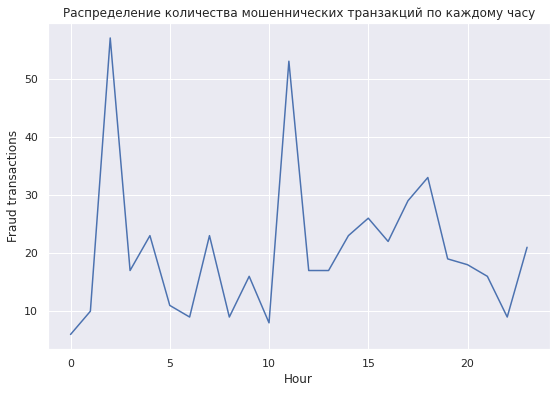

In [11]:
# количество мошеннических транзакций
sns.set(rc={'figure.figsize':(9,6)})
sns.lineplot(data=data, x='Hour', y = 'Fraud transactions').set(title='Распределение количества мошеннических транзакций по каждому часу')

Похоже на рандом больше, чем на закономерность. Ну, можем сделать вывод, что мошенники любят работать больше всего в 2 часа ночи и 11 часов дня :) 

In [12]:
days = df['Day'].value_counts().sort_index().keys()
values_days = df['Day'].value_counts().sort_index()
fraud_days = fraud['Day'].value_counts().sort_index() / df['Day'].value_counts().sort_index()

data = pd.DataFrame({'Day': days, 'Transactions / day': values_days, '% Fraud transactions / day': fraud_days})
data.head()

,Day,Transactions / day,% Fraud transactions / day
0.0,0.0,144786,0.001941
1.0,1.0,140021,0.001507


Text(0.5, 1.0, 'Доля мошеннических транзакций по дням')

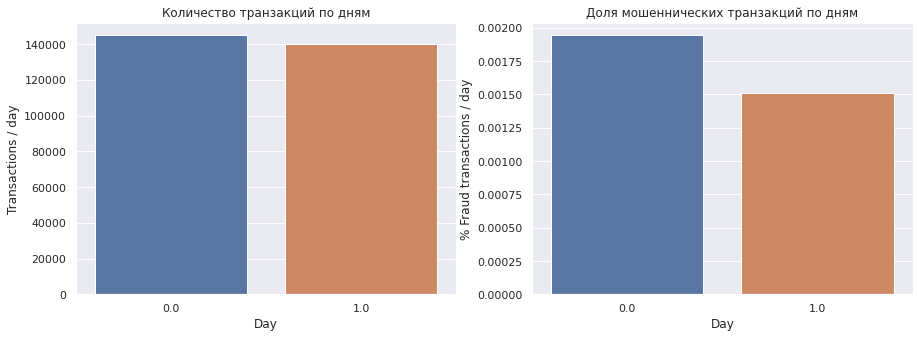

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.barplot(ax=axes[0], data=data, x='Day', y='Transactions / day')
axes[0].set_title('Количество транзакций по дням')

sns.barplot(ax=axes[1],  data=data, x='Day', y='% Fraud transactions / day')
axes[1].set_title('Доля мошеннических транзакций по дням')

По дням: выборка покрывает два дня, в которые было сделано примерно одинаковое количество транзакций. В первый день было сделано относительно больше мошеннических транзакций, чем во второй, так как доля выше - это мы видим на графике справа.

С анонимизированными признаками вряд ли можно придумать что-то интересное. Попробуйте (например, с помощью корреляции?) выбрать несколько наиболее важных признаков и поглядеть на различия в их распределении для разных классов.

In [14]:
df.corr()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Hour,Day
Time,1.000000,1.173963e-01,-1.059333e-02,-4.196182e-01,-1.052602e-01,1.730721e-01,-6.301647e-02,8.471437e-02,-3.694943e-02,-8.660434e-03,3.061663e-02,-2.476894e-01,1.243481e-01,-6.590202e-02,-9.875682e-02,-1.834533e-01,1.190287e-02,-7.329721e-02,9.043813e-02,2.897530e-02,-5.086602e-02,4.473573e-02,1.440591e-01,5.114236e-02,-1.618187e-02,-2.330828e-01,-4.140710e-02,-5.134591e-03,-9.412688e-03,-0.010596,-0.012323,0.415575,0.896490
V1,0.117396,1.000000e+00,4.135835e-16,-1.227819e-15,-9.215150e-16,1.812612e-17,-6.506567e-16,-1.005191e-15,-2.433822e-16,-1.513678e-16,7.388135e-17,2.125498e-16,2.053457e-16,-2.425603e-17,-5.020280e-16,3.547782e-16,7.212815e-17,-3.879840e-16,3.230206e-17,1.502024e-16,4.654551e-16,-2.457409e-16,-4.290944e-16,6.168652e-16,-4.425156e-17,-9.605737e-16,-1.581290e-17,1.198124e-16,2.083082e-15,-0.227709,-0.101347,-0.005214,0.131838
V2,-0.010593,4.135835e-16,1.000000e+00,3.243764e-16,-1.121065e-15,5.157519e-16,2.787346e-16,2.055934e-16,-5.377041e-17,1.978488e-17,-3.991394e-16,1.975426e-16,-9.568710e-17,6.295388e-16,-1.730566e-16,-4.995814e-17,1.177316e-17,-2.685296e-16,3.284605e-16,-7.118719e-18,2.506675e-16,-8.480447e-17,1.526333e-16,1.634231e-16,1.247925e-17,-4.478846e-16,2.057310e-16,-4.966953e-16,-5.093836e-16,-0.531409,0.091289,0.007802,-0.015474
V3,-0.419618,-1.227819e-15,3.243764e-16,1.000000e+00,4.711293e-16,-6.539009e-17,1.627627e-15,4.895305e-16,-1.268779e-15,5.568367e-16,1.156587e-15,1.576830e-15,6.310231e-16,2.807652e-16,4.739859e-16,9.068793e-16,8.299445e-16,7.614712e-16,1.509897e-16,3.463522e-16,-9.316409e-16,5.706192e-17,-1.133902e-15,-4.983035e-16,2.686834e-19,-1.104734e-15,-1.238062e-16,1.045747e-15,9.775546e-16,-0.210880,-0.192961,-0.021569,-0.450604
V4,-0.105260,-9.215150e-16,-1.121065e-15,4.711293e-16,1.000000e+00,-1.719944e-15,-7.491959e-16,-4.104503e-16,5.697192e-16,6.923247e-16,2.232685e-16,3.459380e-16,-5.625518e-16,1.303306e-16,2.282280e-16,1.377649e-16,-9.614528e-16,-2.699612e-16,-5.103644e-16,-3.980557e-16,-1.857247e-16,-1.949553e-16,-6.276051e-17,9.164206e-17,1.584638e-16,6.070716e-16,-4.247268e-16,3.977061e-17,-2.761403e-18,0.098732,0.133447,-0.035063,-0.098590
V5,0.173072,1.812612e-17,5.157519e-16,-6.539009e-17,-1.719944e-15,1.000000e+00,2.408382e-16,2.715541e-16,7.437229e-16,7.391702e-16,-5.202306e-16,7.203963e-16,7.412552e-16,5.886991e-16,6.565143e-16,-8.720275e-16,2.246261e-15,1.281914e-16,5.308590e-16,-1.450421e-16,-3.554057e-16,-3.920976e-16,1.253751e-16,-8.428683e-18,-1.149255e-15,4.808532e-16,4.319541e-16,6.590482e-16,-5.613951e-18,-0.386356,-0.094974,-0.035134,0.207430
V6,-0.063016,-6.506567e-16,2.787346e-16,1.627627e-15,-7.491959e-16,2.408382e-16,1.000000e+00,1.191668e-16,-1.104219e-16,4.131207e-16,5.932243e-17,1.980503e-15,2.375468e-16,-1.211182e-16,2.621312e-16,-1.531188e-15,2.623672e-18,2.015618e-16,1.223814e-16,-1.865597e-16,-1.858755e-16,5.833316e-17,-4.705235e-19,1.046712e-16,-1.071589e-15,4.562861e-16,-1.357067e-16,-4.452461e-16,2.594754e-16,0.215981,-0.043643,-0.018945,-0.059994
V7,0.084714,-1.005191e-15,2.055934e-16,4.895305e-16,-4.104503e-16,2.715541e-16,1.191668e-16,1.000000e+00,3.344412e-16,1.122501e-15,-7.492834e-17,1.425248e-16,-3.536655e-18,1.266462e-17,2.607772e-16,-1.690540e-16,5.869302e-17,2.177192e-16,7.604126e-17,-1.881008e-16,9.379684e-16,-2.027779e-16,-8.898922e-16,-4.387401e-16,7.434913e-18,-3.094082e-16,-9.657637e-16,-1.782106e-15,-2.776530e-16,0.397311,-0.187257,-0.009729,0.097864
V8,-0.036949,-2.433822e-16,-5.377041e-17,-1.268779e-15,5.697192e-16,7.437229e-16,-1.104219e-16,3.344412e-16,1.000000e+00,4.356078e-16,-2.801370e-16,2.487043e-16,1.839891e-16,-2.921856e-16,-8.599156e-16,4.127777e-16,-5.254741e-16,-2.269549e-16,-3.667974e-16,-3.875186e-16,2.033737e-16,3.892798e-16,2.026927e-16,6.377260e-17,-1.047097e-16,-4.653279e-16,-1.727276e-16,1.299943e-16,-6.200930e-16,-0.103079,0.019875,0.032106,-0.056331
V9,-0.008660,-1.

Что тут происходит:

Я считаю корреляции всех признаков с целевой переменной и сортирую переменные по возрастанию абсолютного значения корреляции. 
Для рисования распределений я взяла 6 наиболее коррелирующих переменных.

In [15]:
corrs = abs(df.corr()['Class']).to_dict()
dict(sorted(corrs.items(), key=lambda item: item[1]))

{'Amount': 0.005631753006768552,
 'Class': 1.0,
 'Day': 0.0052233078855685846,
 'Hour': 0.017108561324646897,
 'Time': 0.012322570929245588,
 'V1': 0.10134729859508294,
 'V10': 0.21688294364103206,
 'V11': 0.15487564474394433,
 'V12': 0.26059292487722485,
 'V13': 0.004569778799461309,
 'V14': 0.3025436958044028,
 'V15': 0.004223402267856675,
 'V16': 0.19653894030401736,
 'V17': 0.32648106724371595,
 'V18': 0.11148525388904133,
 'V19': 0.034783013036515056,
 'V2': 0.0912886503446179,
 'V20': 0.020090324196974638,
 'V21': 0.04041338061057565,
 'V22': 0.0008053175052983079,
 'V23': 0.0026851557402507824,
 'V24': 0.007220906715952582,
 'V25': 0.0033077055972996613,
 'V26': 0.0044553975012833254,
 'V27': 0.01757972818951348,
 'V28': 0.00953604091623609,
 'V3': 0.19296082706741602,
 'V4': 0.13344748623900718,
 'V5': 0.09497429899144802,
 'V6': 0.04364316069996494,
 'V7': 0.18725659151430013,
 'V8': 0.019875123914794384,
 'V9': 0.0977326860740807}

In [16]:
# код отрисовки гистограмм взят отсюда (и слегка адаптирован)
# https://github.com/hse-ds/iad-applied-ds/tree/master/2022/hw/hw1

def plot_hists(X1, X2, vs, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(4*4, 4*2))
    for i in range(6):
        plt.subplot(2, 3, i+1)
        plt.hist(X1.iloc[:, vs[i]], bins=bins, alpha=0.5, label=label1, color='C0', density=True)
        plt.hist(X2.iloc[:, vs[i]], bins=bins, alpha=0.5, label=label2, color='C1', density=True)
        plt.xlabel('V'+str(vs[i]), size=14)
        plt.legend(loc='best')
    plt.tight_layout()

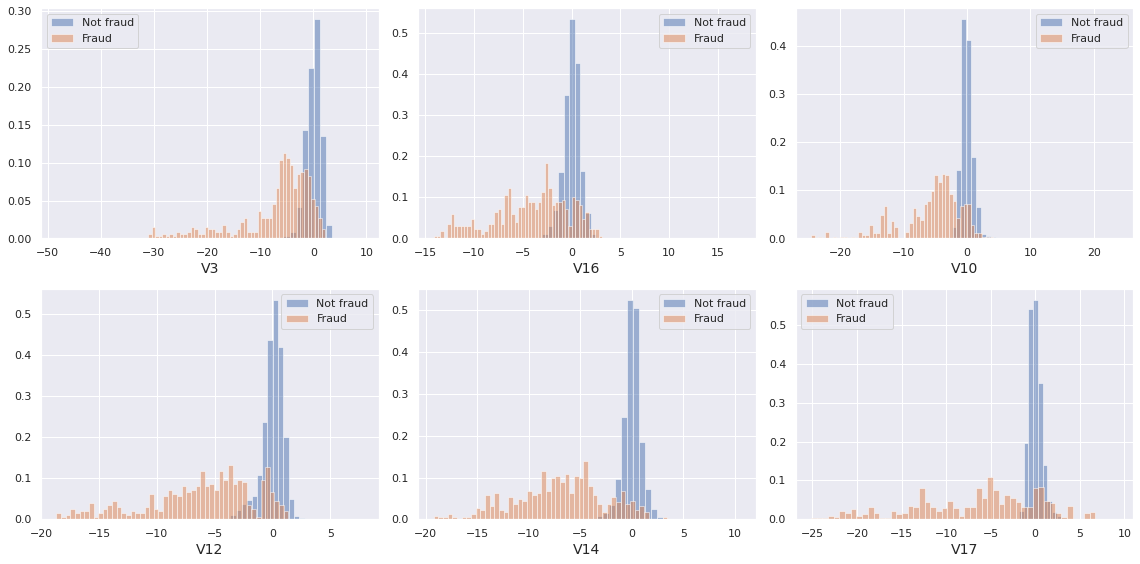

In [17]:
fraud = df[df['Class']==1]
not_fraud = df[df['Class']==0]
var_list = [3, 16, 10, 12, 14, 17] # это список из наиболее коррелирующих переменных, по нему будем итерироваться и рисовать гистограммы

plot_hists(not_fraud, fraud, var_list, label1="Not fraud", label2="Fraud", bins=50)

Видим, что распределения для мошеннических и нормальных транзакций довольно сильно отличаются друг от друга. Нормальные транзакции распределены более нормально (с днем каламбуров!) со средним значением в 0 и маленьким разбросом (дисперсией). Мошеннические приобретают много разных значений и как правило не концентрируются в нуле. 

Теперь давайте разделим данные. Отделите хронологически последние 20% транзакций и поделите их пополам (также хронологически, т.е. без перемешивания) на валидационные и тестовые. Это разбиение не совсем корректно (как можно было заметить, мошеннические транзакции имеют разное распределение во времени - по-хорошему, нам стоило бы выделить целые сутки записей как под валидацию, так и под тест), тем не менее, мы не сможем получить больше данных для адекватного контроля, поэтому обойдемся этим. 

In [18]:
train_df = df[:int(len(df)*0.8)]
val_df = df[int(len(df)*0.8):int(len(df)*0.9)]
test_df = df[int(len(df)*0.9):]

assert len(val_df) == len(test_df)
assert len(train_df)+len(val_df)+len(test_df) == len(df)

In [19]:
y_train = train_df['Class']
X_train = train_df.drop('Class', axis=1)
y_val = val_df['Class']
X_val = val_df.drop('Class', axis=1)
y_test = test_df['Class']
X_test = test_df.drop('Class', axis=1)

Done

# Часть 1. Несбалансированная классификация.

**Задание 0. (1 балл)**: перед началом работы давайте поговорим о том, как мы будем оценивать качество. Классические метрики для качества классификации чаще всего "ломаются" на задачах с сильным перекосом. Чему будет равно значение accuracy для наивного предсказания (= мажорный класс для каждого объекта)? (можете не отвечать, просто подумайте)

Из курса МО-1 вам уже известно, что мы можем использовать в таких задачах `AUC-PR` и получать адекватные показатели. Можно сказать, что `AUC-PR` представляет собой матожидание `precision` по распределению, заданному выигрышем в `recall` при смене порога. 

In [20]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

Тем не менее, существуют и другие, не менее интересные метрики. Одной из таких метрик является коэффициент Каппа Коэна, представляющий собой нормализованную `accuracy`:

$$\kappa = \frac{p_o - p_e}{1 - p_e}$$

Данная метрика служит в качестве меры согласованности между двумя независимыми предсказателями, но ничего не знает про "верные" и "предсказанные" метки (в отличие от многих других метрик машинного обучения). Здесь $p_o$ - доля согласованных предсказаний, а $p_e$ - доля согласованных предсказаний, которая могла бы получиться при случайных ответах предсказателей. В нашем случае это работает так:

• В качестве $p_o$ берем accuracy

• В качестве $p_e$ примем следующую величину - вероятность случайного соглашения позитивных ответов (произведение долей позитивных ответов в обоих предсказаниях) плюс вероятность случайного соглашения негативных ответов (произведение долей негативных ответов в обоих предсказаниях)

Метрика принимает значения от -1 до 1, где 1 - полная согласованность, 0 - согласованность на уровне рандома, -1 - совсем плохо. Как уже говорилось, метрика не различает "верные" и "предсказанные" метки, поэтому является симметричной (можете использовать это для отладки):

In [21]:
from sklearn.metrics import cohen_kappa_score

Еще одной метрикой в такой задаче служит коэффициент корреляции Мэтьюза, выражающийся в терминах матрицы ошибок следующим образом:

$$\text{MCC} = \frac{TP\times TN - FP \times FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}$$ 

Метрика принимает значения от -1 до 1, интерпретируемые аналогичным образом. 

In [22]:
from sklearn.metrics import matthews_corrcoef

Обратите внимание, что эти метрики вычисляются на бинаризованных предсказаниях, поэтому может иметь смысл дополнительная настройка порога бинаризации.

Давайте проверим, что наши метрики действительно подходят под задачу. Вычислите их значения для наивного предсказания (aka мажорный класс для всех объектов):

Можно оценивать PR-AUC по разному: либо считать площадь под кривой с помощью правила трапеции (или как-то так), а можно использовать метрику Average Precision, что в общем-то не тоже самое. Я буду считать обе эти метрики, но больше обращать внимание на PR-AUC как сказано в задании. По AP получаются менее оптимистические значения качества :)

In [23]:
# пропишем расчет площади под кривой PR, чтобы не таскать за собой
def pr_auc(y_true, y_pred):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    return auc(recall, precision)

# потестим
pr_auc(df['Class'], np.zeros(len(df['Class'])))

0.50086374281531

In [24]:
y_true = df['Class']
y_pred = np.zeros(len(df['Class']))

print('Average precision:', average_precision_score(y_true, y_pred), 
      '\nPR-AUC:', pr_auc(y_true, y_pred),
      '\nCohen-Kappa coefficient:', cohen_kappa_score(y_true, y_pred),
      '\nMatthews coeficient:', matthews_corrcoef(y_true, y_pred))

Average precision: 0.001727485630620034 
PR-AUC: 0.50086374281531 
Cohen-Kappa coefficient: 0.0 
Matthews coeficient: 0.0


PR-AUC около 0,5 говорит о том, что перед нами случайный классификатор. Значения коэффициентов K и MCC равные нулю - то же самое. Это хорошо, потому что можно считать наивный классификатор в каком-то смысле случайным. Вывод: метрики подходят под нашу задачу. + метрики согласуются между собой

Давайте запустим бейзлайн-решение для нашей задачи. С чего же начнем? Возьмите `catboost` и обучите его классификатор на наших данных (используйте все признаки). Вычислите значения всех метрик на тестовой части, для контроля переобучения используйте валидационную (здесь и далее везде, где фигурирует `catboost`). 

In [18]:
#!pip install catboost 
# installing for colab

     |████████████████████████████████| 76.6 MB 1.1 MB/s 


In [25]:
from catboost import CatBoostClassifier

In [26]:
model = CatBoostClassifier(metric_period=100)

model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)

y_pred = model.predict(X_test)
y_true = y_test

print('\nAverage precision:', average_precision_score(y_true, y_pred), 
      '\nPR-AUC:', pr_auc(y_true, y_pred),
      '\nCohen-Kappa coefficient:', cohen_kappa_score(y_true, y_pred),
      '\nMatthews coeficient:', matthews_corrcoef(y_true, y_pred))

Learning rate set to 0.104628
0:	learn: 0.3703799	total: 363ms	remaining: 6m 2s
100:	learn: 0.0014914	total: 15.3s	remaining: 2m 16s
200:	learn: 0.0011399	total: 24.8s	remaining: 1m 38s
300:	learn: 0.0008503	total: 30.8s	remaining: 1m 11s
400:	learn: 0.0006065	total: 37.2s	remaining: 55.6s
500:	learn: 0.0004058	total: 45.7s	remaining: 45.5s
600:	learn: 0.0002833	total: 56s	remaining: 37.2s
700:	learn: 0.0001968	total: 1m 2s	remaining: 26.6s
800:	learn: 0.0001514	total: 1m 8s	remaining: 17.1s
900:	learn: 0.0001204	total: 1m 15s	remaining: 8.28s
999:	learn: 0.0001105	total: 1m 21s	remaining: 0us

Average precision: 0.5570990708319102 
PR-AUC: 0.7558222626886824 
Cohen-Kappa coefficient: 0.7366708149419272 
Matthews coeficient: 0.7460414610269303


In [27]:
print('\nAverage precision:', average_precision_score(y_train, y_pred_train), 
      '\nPR-AUC:', pr_auc(y_train, y_pred_train),
      '\nCohen-Kappa coefficient:', cohen_kappa_score(y_train, y_pred_train),
      '\nMatthews coeficient:', matthews_corrcoef(y_train, y_pred_train))


Average precision: 0.9976063074138551 
PR-AUC: 0.9988031537069276 
Cohen-Kappa coefficient: 0.9987973213179445 
Matthews coeficient: 0.9987980436669355


Мне кажется, здесь не особо есть смысл контролить переобучение и подбирать оптимальные гиперпараметры. На трейне все метрики дают качество ~1, так что в любом случае будет большая разница между качеством на трейне и тесте (что является признаком переобучения). В последующих заданиях я буду использовать валидационную выборку для подбора интересных гиперпараметров, но тут хочется остановиться на том, что есть. Давайте считать бейзлайном модель с дефолтными гиперпараметрами.

Если вы все сделали правильно, у вас должны были получиться значения в районе 0.7.

Yep

**Задание 1. (1 балл)**. Многие реализации методов предлагают встроенные способы для борьбы с нашей проблемой. Самое часто встречающееся решение - просто добавить вес в функции потерь для минорного класса (таким образом, ошибка на объекте минорного класса будет весить больше, чем для мажорного). В `catboost` это также реализовано, причем для бинарной задачи это можно сделать целыми двумя способами (можете выбрать любой, на свой вкус, автор задания предпочитает отдельный скейлинг для минорного класса). Чаще всего в качестве веса берется отношение числа объектов мажорного класса к числу минорного. Попробуйте обучить модель с таким скалированием и сравните метрики на тестовой части с бейзлайном.

In [28]:
special_weight = sum(y_train == 0) / sum(y_train == 1)

model = CatBoostClassifier(class_weights=[1, special_weight], metric_period=100)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_true = y_test

print('\nAverage precision:', average_precision_score(y_true, y_pred), 
      '\nPR-AUC:', pr_auc(y_true, y_pred),
      '\nCohen-Kappa coefficient:', cohen_kappa_score(y_true, y_pred),
      '\nMatthews coeficient:', matthews_corrcoef(y_true, y_pred))

Learning rate set to 0.104628
0:	learn: 0.5119885	total: 79.4ms	remaining: 1m 19s
100:	learn: 0.0056327	total: 8.1s	remaining: 1m 12s
200:	learn: 0.0017081	total: 14.7s	remaining: 58.6s
300:	learn: 0.0012717	total: 20.8s	remaining: 48.4s
400:	learn: 0.0011889	total: 26.5s	remaining: 39.5s
500:	learn: 0.0011614	total: 32.3s	remaining: 32.1s
600:	learn: 0.0011369	total: 37.9s	remaining: 25.1s
700:	learn: 0.0011369	total: 43.4s	remaining: 18.5s
800:	learn: 0.0011302	total: 48.9s	remaining: 12.1s
900:	learn: 0.0011297	total: 55.5s	remaining: 6.1s
999:	learn: 0.0011295	total: 1m 1s	remaining: 0us

Average precision: 0.5256301010881258 
PR-AUC: 0.7264514141804266 
Cohen-Kappa coefficient: 0.7231767758972476 
Matthews coeficient: 0.72465693045526


Метрики не сломались, но результаты получились чуть слабее, чем у бейзлайна. Значения снизились на несколько сотых (в разной мере для разных метрик).

Поскольку данный вес будет являться гиперпараметром метода, было бы опрометчиво остановиться на одном значении (тем более, с большой вероятностью у вас все сломалось). Запустите перебор для этого гиперпараметра на валидационной выборке (используйте `PR-AUC`), подберите оптимальный порог бинаризации для $\kappa$ или $\text{MCC}$. Для лучшего найденного веса и порога вычислите все метрики на тестовой части. 

При этом можете также проверить отдельное скалирование в большую сторону для мажорного класса (т.е. веса минорного сделать меньше 1) и экстремальные скалирования (т.е. веса минорного больше, чем в начале этого задания). Какой вес получился оптимальным?

In [29]:
# смотрим на соотношение классов, чтобы потестить другие веса для минорного класса
sum(y_train == 0) / sum(y_train == 1)

545.3908872901678

In [30]:
weights = [0.1, 0.5, 1, 5, 10, 50, 100, 500, 750, 1000] # попробуем такие 
scores = []
cnt = 1

for w in weights:
    print('Fit'+str(cnt))
    model = CatBoostClassifier(class_weights=[1, w], metric_period=100)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_true = y_val
    
    pr_auc_score = pr_auc(y_true, y_pred)
    scores.append(pr_auc_score)
    cnt += 1

print('\nBest validation score:', max(scores), 
      '\nBest weight:', weights[np.argmax(np.array(scores))])

Fit1
Learning rate set to 0.104628
0:	learn: 0.3410884	total: 97.2ms	remaining: 1m 37s
100:	learn: 0.0003047	total: 7.04s	remaining: 1m 2s
200:	learn: 0.0002595	total: 13.7s	remaining: 54.3s
300:	learn: 0.0002371	total: 20.2s	remaining: 47s
400:	learn: 0.0002255	total: 26.7s	remaining: 39.9s
500:	learn: 0.0002138	total: 33.3s	remaining: 33.2s
600:	learn: 0.0002039	total: 40s	remaining: 26.5s
700:	learn: 0.0001934	total: 46.8s	remaining: 20s
800:	learn: 0.0001855	total: 53.6s	remaining: 13.3s
900:	learn: 0.0001767	total: 1m	remaining: 6.61s
999:	learn: 0.0001703	total: 1m 6s	remaining: 0us
Fit2
Learning rate set to 0.104628
0:	learn: 0.3570405	total: 81.4ms	remaining: 1m 21s
100:	learn: 0.0009550	total: 6.94s	remaining: 1m 1s
200:	learn: 0.0007854	total: 13.6s	remaining: 54.1s
300:	learn: 0.0006601	total: 20.4s	remaining: 47.3s
400:	learn: 0.0005650	total: 26.9s	remaining: 40.2s
500:	learn: 0.0004874	total: 33.4s	remaining: 33.3s
600:	learn: 0.0003961	total: 40.2s	remaining: 26.7s
700:	

Код выше автоматически нашел "лучший вес" и лучший скор на валидационной выборке. Посмотрим, какие в целом получились скоры.

In [31]:
scores

[0.8459333866675935,
 0.8361795980504713,
 0.8493374927873133,
 0.8750983576857231,
 0.8750983576857231,
 0.8750983576857231,
 0.8637473056369966,
 0.8425586751460405,
 0.8432280369295758,
 0.8630861929579446]

Обнаружен подвох. У нас получилось три значения веса, для которых на валидации получается одинаковый скор: 5, 10, 50. Можем считать, что любой из них нам подходит для этой задачи. 

In [32]:
borders = [0.1, 0.4, 0.5, 0.6, 0.9, 0.99]
scores = []
cnt = 1

for b in borders:
    print('Fit'+str(cnt))
    model = CatBoostClassifier(class_weights=[1, 10], target_border=b, metric_period=100)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_true = y_val
    
    mcc =  matthews_corrcoef(y_true, y_pred)
    scores.append(mcc)
    cnt += 1

print('\nBest validation score:', max(scores), 
      '\nBest target border:', borders[np.argmax(np.array(scores))])

Fit1
Learning rate set to 0.104628
0:	learn: 0.4254936	total: 79.4ms	remaining: 1m 19s
100:	learn: 0.0042874	total: 7.18s	remaining: 1m 3s
200:	learn: 0.0011678	total: 14.4s	remaining: 57.1s
300:	learn: 0.0005278	total: 21s	remaining: 48.8s
400:	learn: 0.0002821	total: 27.6s	remaining: 41.2s
500:	learn: 0.0002117	total: 33.6s	remaining: 33.5s
600:	learn: 0.0001943	total: 39.2s	remaining: 26s
700:	learn: 0.0001733	total: 44.8s	remaining: 19.1s
800:	learn: 0.0001548	total: 50.3s	remaining: 12.5s
900:	learn: 0.0001516	total: 55.7s	remaining: 6.12s
999:	learn: 0.0001492	total: 1m	remaining: 0us
Fit2
Learning rate set to 0.104628
0:	learn: 0.4254936	total: 71.1ms	remaining: 1m 11s
100:	learn: 0.0042874	total: 6.72s	remaining: 59.8s
200:	learn: 0.0011678	total: 13.7s	remaining: 54.3s
300:	learn: 0.0005278	total: 20.6s	remaining: 47.8s
400:	learn: 0.0002821	total: 27.7s	remaining: 41.4s
500:	learn: 0.0002117	total: 34.2s	remaining: 34.1s
600:	learn: 0.0001943	total: 40.4s	remaining: 26.8s
700

Лучший порог: 0.1 для веса 10.

In [35]:
model = CatBoostClassifier(class_weights=[1, 50], target_border=0.1, metric_period=100)

model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)

y_pred = model.predict(X_test)
y_true = y_test

print('\nAverage precision:', average_precision_score(y_true, y_pred), 
      '\nPR-AUC:', pr_auc(y_true, y_pred),
      '\nCohen-Kappa coefficient:', cohen_kappa_score(y_true, y_pred),
      '\nMatthews coeficient:', matthews_corrcoef(y_true, y_pred))

Learning rate set to 0.104628
0:	learn: 0.4883719	total: 130ms	remaining: 2m 10s
100:	learn: 0.0058054	total: 10.7s	remaining: 1m 35s
200:	learn: 0.0013988	total: 17.6s	remaining: 1m 10s
300:	learn: 0.0006568	total: 24.4s	remaining: 56.7s
400:	learn: 0.0005879	total: 30s	remaining: 44.9s
500:	learn: 0.0005817	total: 35.6s	remaining: 35.5s
600:	learn: 0.0005441	total: 41.9s	remaining: 27.8s
700:	learn: 0.0005423	total: 47.8s	remaining: 20.4s
800:	learn: 0.0004865	total: 53.7s	remaining: 13.3s
900:	learn: 0.0004647	total: 59.3s	remaining: 6.52s
999:	learn: 0.0004126	total: 1m 5s	remaining: 0us

Average precision: 0.5543232208728505 
PR-AUC: 0.7446940779688928 
Cohen-Kappa coefficient: 0.7439928940257028 
Matthews coeficient: 0.7441944677557768


Здесь я посчитала значения метрик для порога бинаризации 0.1 и веса минорного класса 50. В целом получились более хорошие значения, чем в предыдущем варианте и в среднем примерно такие же, как на бейзлайне.

**Задание 2. (1 балл)**. На самом деле, то, что мы сейчас делали, очень схоже с другой распространенной техникой - оверсэмплингом. Фактически, мы можем продублировать все объекты минорного класса и получить тот же эффект, какой был бы при использовании веса, равного 2. Тем не менее, такой подход - это лишь малая часть того, что мы можем проделать с целью повысить число объектов минорного класса. 

Для продолжения работы установим библиотеку [imbalanced-learn](https://imbalanced-learn.org/stable/):

In [ ]:
#!pip3 install imbalanced-learn

  Using cached imbalanced_learn-0.9.0-py3-none-any.whl (199 kB)


Первый метод, которым мы воспользуемся, называется SMOTE (его вы уже разбирали на лекции). Кратко напомним суть: мы выбираем случайного кандидата среди $k$ ближайших соседей объекта минорного класса, затем берем точку на отрезке между двумя объектами (т.е. выпуклую комбинацию со случайными коэффициентами) и добавляем в выборку. 

In [36]:
from imblearn.over_sampling import SMOTE

Используйте SMOTE для ресэмплинга обучающей выборки, на новой выборке обучите модель (вес положительных объектов скалировать не нужно). Замерьте качество на тестовой выборке (**важно!** не преобразовывайте валидационную и тестовую выборку никак - мы не хотим отслеживать качество на объектах, которых в реальности не существует). Сравните полное выравнивание выборки с частичным (т.е. таким, что баланс классов улучшается, но не достигает равенства - скажем, 1:2 и 1:10).

In [37]:
balance = [1, 0.5, 0.1] # сразу прогоним значения баланса классов в цикле и сравним в табличке
ap = []
prauc = []
ck = []
mcc = []

for b in balance:
    
    sm = SMOTE(sampling_strategy=b, random_state=690)
    X_res, y_res = sm.fit_resample(X_train, y_train)
    
    model = CatBoostClassifier(iterations=1000, metric_period=100) 

    model.fit(X_res, y_res)
    y_pred = model.predict(X_test)
    y_true = y_test
    
    ap.append(average_precision_score(y_true, y_pred))
    prauc.append(pr_auc(y_true, y_pred))
    ck.append(cohen_kappa_score(y_true, y_pred))
    mcc.append(matthews_corrcoef(y_true, y_pred))
    
pd.DataFrame(data = {'Average Precision': ap, 'PR-AUC':prauc, 'Cohen-Kappa':ck, 'Matthews':mcc}, index=balance)

Learning rate set to 0.140555
0:	learn: 0.4020992	total: 176ms	remaining: 2m 55s
100:	learn: 0.0065168	total: 13.5s	remaining: 1m 59s
200:	learn: 0.0031334	total: 25.8s	remaining: 1m 42s
300:	learn: 0.0031109	total: 37.8s	remaining: 1m 27s
400:	learn: 0.0031109	total: 49.3s	remaining: 1m 13s
500:	learn: 0.0030996	total: 1m	remaining: 1m
600:	learn: 0.0030589	total: 1m 11s	remaining: 47.4s
700:	learn: 0.0030589	total: 1m 22s	remaining: 35.1s
800:	learn: 0.0030589	total: 1m 33s	remaining: 23.3s
900:	learn: 0.0030589	total: 1m 44s	remaining: 11.5s
999:	learn: 0.0030589	total: 1m 55s	remaining: 0us
Learning rate set to 0.124308
0:	learn: 0.4295584	total: 119ms	remaining: 1m 59s
100:	learn: 0.0084195	total: 10.6s	remaining: 1m 33s
200:	learn: 0.0027894	total: 20.5s	remaining: 1m 21s
300:	learn: 0.0021638	total: 29.7s	remaining: 1m 9s
400:	learn: 0.0018912	total: 38.8s	remaining: 58s
500:	learn: 0.0018210	total: 46.7s	remaining: 46.5s
600:	learn: 0.0016069	total: 54.7s	remaining: 36.3s
700:	

,Average Precision,PR-AUC,Cohen-Kappa,Matthews
1.0,0.447763,0.671434,0.666387,0.668717
0.5,0.582029,0.763742,0.761729,0.762596
0.1,0.554323,0.744694,0.743993,0.744194


Вывод: как ни странно, получается что с уменьшением баланса классов, значения всех метрик увеличиваются. Возможно, когда мы хотим семплировать слишком много объектов минорного класса (относительно мажорного), в данных появляются какие-то взаимосвязи, которых на самом деле нет (мб в том числе из-за шумовых точек, так как SMOTE никак не различает шум), поэтому алгоритм переобучается и на тестовой выборке уже не может хорошо предсказать данные.

По метрикам видим, что мы не превзошли результаты, полученные на использовании весов для минорного класса. Для лучшего SMOTE с балансом 0,1 метрики в среднем как на бейзлайне.

**Бонус (1.5 балла)**. Для vanilla SMOTE существуют некоторые модификации, часть из которых была реализована в библиотеке imblearn. Во время лекций/семинаров эти модификации не рассматривались, тем не менее, мы все равно их исследуем.

Найдите статьи о следующих методах и попробуйте вкратце сформулировать, в чем их основная идея (сделайте так, чтобы человек, знакомый с машинным обучением в целом, но не слышавший конкретно про это смог понять):

____
**BorderlineSMOTE** - совсем вкратце: используем SMOTE на объектах, которые нам кажутся пограничными (близкие к границам разделения между классами). 

Более подробно: Для всех объектов минорного класса рассматриваем их m ближайших соседей и считаем какая доля из m приходится на объекты мажорного класса. Если все мажорные - считаем объект шумовым и забиваем на него. Если меньшая часть мажорная - этот объект хороший (ака "внутренний"), также забиваем. Если большая часть мажорная - этот объект опасный. Получаем множество опасных объектов, вот из этой выборки будем синтетически семплировать минорный класс. (как раз SMOTE)

сорс: https://sci2s.ugr.es/keel/pdf/specific/congreso/han_borderline_smote.pdf

SVM-SMOTE - совсем вкратце: здесь мы тоже считаем крутой идей генерировать объекты минорного класса рядом с разделяющими плоскостями, только теперь мы прикручиваем сюда SVM для определения плоскостей. 

Немного подробнее: сначала используем метод опорных векторов, чтобы аппроксимировать разделяющую гиперплоскость. Новые объекты будем генерировать вдоль нее либо с помощью интерполяции, либо с помощью экстраполяции (зависит от баланса классов среди ближайших соседей).

сорс: https://ir.lib.hiroshima-u.ac.jp/files/public/2/28413/20141016164340528778/A1005.pdf 

K-Means-SMOTE - совсем вкратце: авторы были очень вдохновлены идей о том, что метод семплирования не должен генерировать синтетические объекты из шумовых точек, а также должен учитывать как межклассовую, так и внутриклассовую несбалансированность и прикрутили к SMOTE кластеризацию k-Means.

Немного подробнее: алгоритм состоит из трех шагов: кластеризация, фильтрация и оверсемплинг. 1) Применяем k-means, чтобы разделить данные на кластеры. 2) В каждом кластере считаем imbalance ratio (IR) = количество объектов минорного класса / количество объектов мажорного. Выбираем для семплирования те кластеры, в которых IR>1 (то есть области с преобладанием минорного класса). 3) Используем SMOTE для генерации объектов в кластерах, выбранных на предыдущем шаге. (При этом мы сами задаем желаемый баланс классов и стремимся к нему)

сорс: https://arxiv.org/pdf/1711.00837.pdf (с картинками!!! :)) ) 

ADASYN - совсем вкратце: это как SMOTE, только с учетом различных весов для каждого объекта минорного класса. 

Немного подробнее: задаем гиперпараметры (типа какой для нас баланс классов является приемлемым и проч.), потом рассчитываем по всяким формулам распределения для объектов минорного класса и генерируем новые объекты из линейной комбинации существующих с учетом распределений. В статье написано, что алгоритм позволяемт концентрироваться на сложно обучаемых объектах. 

сорс: https://www.researchgate.net/publication/224330873_ADASYN_Adaptive_Synthetic_Sampling_Approach_for_Imbalanced_Learning 

Теперь попробуйте сравнить качество всех методов на наших данных.

In [38]:
from imblearn.over_sampling import BorderlineSMOTE 
from imblearn.over_sampling import SVMSMOTE 
from imblearn.over_sampling import KMeansSMOTE
from imblearn.over_sampling import ADASYN 

In [39]:
methods=['Borderline SMOTE', 'SVM SMOTE', 'K-Means SMOTE', 'ADASYN']
prauc=[]
ck=[]
mcc=[]

In [40]:
sampler = BorderlineSMOTE(sampling_strategy=0.1, random_state=690) # change sampling strategy to optimal 
X_res, y_res = sampler.fit_resample(X_train, y_train)
    
model = CatBoostClassifier(iterations=1000, metric_period=100) 

model.fit(X_res, y_res)
y_pred = model.predict(X_test)
y_true = y_test

print('\nAverage precision:', average_precision_score(y_true, y_pred), 
      '\nPR-AUC:', pr_auc(y_true, y_pred),
      '\nCohen-Kappa coefficient:', cohen_kappa_score(y_true, y_pred),
      '\nMatthews coeficient:', matthews_corrcoef(y_true, y_pred))
prauc.append(pr_auc(y_true, y_pred))
ck.append(cohen_kappa_score(y_true, y_pred))
mcc.append(matthews_corrcoef(y_true, y_pred))

Learning rate set to 0.108888
0:	learn: 0.4007618	total: 73.7ms	remaining: 1m 13s
100:	learn: 0.0020035	total: 7.23s	remaining: 1m 4s
200:	learn: 0.0014374	total: 13.8s	remaining: 54.9s
300:	learn: 0.0013138	total: 22.8s	remaining: 52.8s
400:	learn: 0.0013137	total: 29.5s	remaining: 44.1s
500:	learn: 0.0012935	total: 35.5s	remaining: 35.4s
600:	learn: 0.0012054	total: 41.8s	remaining: 27.7s
700:	learn: 0.0010947	total: 47.9s	remaining: 20.4s
800:	learn: 0.0010755	total: 53.7s	remaining: 13.4s
900:	learn: 0.0010685	total: 59.6s	remaining: 6.55s
999:	learn: 0.0010380	total: 1m 5s	remaining: 0us

Average precision: 0.6018500559618787 
PR-AUC: 0.7822084504408323 
Cohen-Kappa coefficient: 0.7690752614163283 
Matthews coeficient: 0.7754834690252622


In [41]:
sampler = SVMSMOTE(sampling_strategy=0.1, random_state=690)
X_res, y_res = sampler.fit_resample(X_train, y_train)
    
model = CatBoostClassifier(iterations=1000, metric_period=100) 

model.fit(X_res, y_res)
y_pred = model.predict(X_test)
y_true = y_test

print('\nAverage precision:', average_precision_score(y_true, y_pred), 
      '\nPR-AUC:', pr_auc(y_true, y_pred),
      '\nCohen-Kappa coefficient:', cohen_kappa_score(y_true, y_pred),
      '\nMatthews coeficient:', matthews_corrcoef(y_true, y_pred))
prauc.append(pr_auc(y_true, y_pred))
ck.append(cohen_kappa_score(y_true, y_pred))
mcc.append(matthews_corrcoef(y_true, y_pred))

Learning rate set to 0.108888
0:	learn: 0.3900046	total: 74.4ms	remaining: 1m 14s
100:	learn: 0.0019069	total: 7.11s	remaining: 1m 3s
200:	learn: 0.0014866	total: 13.6s	remaining: 54.2s
300:	learn: 0.0014866	total: 18.8s	remaining: 43.7s
400:	learn: 0.0014866	total: 23.9s	remaining: 35.8s
500:	learn: 0.0014819	total: 29.2s	remaining: 29.1s
600:	learn: 0.0014562	total: 34.4s	remaining: 22.9s
700:	learn: 0.0014529	total: 39.4s	remaining: 16.8s
800:	learn: 0.0014528	total: 45.2s	remaining: 11.2s
900:	learn: 0.0014528	total: 50.3s	remaining: 5.53s
999:	learn: 0.0014528	total: 55.4s	remaining: 0us

Average precision: 0.6126508581478561 
PR-AUC: 0.7847943285954593 
Cohen-Kappa coefficient: 0.7803305381421477 
Matthews coeficient: 0.7824309099074692


In [42]:
sampler = KMeansSMOTE(sampling_strategy=0.1, cluster_balance_threshold=0.001, random_state=690) # параметр cluster_balance_threshold задан 
X_res, y_res = sampler.fit_resample(X_train, y_train)                                           # тк иначе RE ошибка из-за малого числа минорных объектов
    
model = CatBoostClassifier(iterations=1000, metric_period=100)

model.fit(X_res, y_res)
y_pred = model.predict(X_test)
y_true = y_test

print('\nAverage precision:', average_precision_score(y_true, y_pred), 
      '\nPR-AUC:', pr_auc(y_true, y_pred),
      '\nCohen-Kappa coefficient:', cohen_kappa_score(y_true, y_pred),
      '\nMatthews coeficient:', matthews_corrcoef(y_true, y_pred))
prauc.append(pr_auc(y_true, y_pred))
ck.append(cohen_kappa_score(y_true, y_pred))
mcc.append(matthews_corrcoef(y_true, y_pred))

Learning rate set to 0.108889
0:	learn: 0.4087275	total: 85ms	remaining: 1m 24s
100:	learn: 0.0018072	total: 7.22s	remaining: 1m 4s
200:	learn: 0.0015767	total: 13.6s	remaining: 54.2s
300:	learn: 0.0015767	total: 19.3s	remaining: 44.7s
400:	learn: 0.0015767	total: 25.2s	remaining: 37.6s
500:	learn: 0.0015767	total: 31s	remaining: 30.9s
600:	learn: 0.0015767	total: 36.7s	remaining: 24.3s
700:	learn: 0.0015767	total: 42.3s	remaining: 18s
800:	learn: 0.0015767	total: 47.8s	remaining: 11.9s
900:	learn: 0.0015767	total: 53.4s	remaining: 5.87s
999:	learn: 0.0015767	total: 59.3s	remaining: 0us

Average precision: 0.6018500559618787 
PR-AUC: 0.7822084504408323 
Cohen-Kappa coefficient: 0.7690752614163283 
Matthews coeficient: 0.7754834690252622


In [43]:
sampler = ADASYN(sampling_strategy=0.1, random_state=690)
X_res, y_res = sampler.fit_resample(X_train, y_train)
    
model = CatBoostClassifier(iterations=1000, metric_period=100) 

model.fit(X_res, y_res)
y_pred = model.predict(X_test)
y_true = y_test

print('\nAverage precision:', average_precision_score(y_true, y_pred), 
      '\nPR-AUC:', pr_auc(y_true, y_pred),
      '\nCohen-Kappa coefficient:', cohen_kappa_score(y_true, y_pred),
      '\nMatthews coeficient:', matthews_corrcoef(y_true, y_pred))
prauc.append(pr_auc(y_true, y_pred))
ck.append(cohen_kappa_score(y_true, y_pred))
mcc.append(matthews_corrcoef(y_true, y_pred))

Learning rate set to 0.108906
0:	learn: 0.4707708	total: 70.7ms	remaining: 1m 10s
100:	learn: 0.0088006	total: 7.53s	remaining: 1m 6s
200:	learn: 0.0031749	total: 15s	remaining: 59.6s
300:	learn: 0.0015447	total: 22.3s	remaining: 51.7s
400:	learn: 0.0009199	total: 29.4s	remaining: 44s
500:	learn: 0.0008563	total: 36.9s	remaining: 36.7s
600:	learn: 0.0007308	total: 43.3s	remaining: 28.7s
700:	learn: 0.0006357	total: 49.7s	remaining: 21.2s
800:	learn: 0.0006103	total: 55.9s	remaining: 13.9s
900:	learn: 0.0006067	total: 1m 2s	remaining: 6.83s
999:	learn: 0.0006037	total: 1m 8s	remaining: 0us

Average precision: 0.5820288485784783 
PR-AUC: 0.7637416970165118 
Cohen-Kappa coefficient: 0.7617294754049536 
Matthews coeficient: 0.7625958622585118


In [30]:
pd.DataFrame(data = {'PR-AUC':prauc, 'Cohen-Kappa':ck, 'Matthews':mcc}, index=methods)

,PR-AUC,Cohen-Kappa,Matthews
Borderline SMOTE,0.782208,0.769075,0.775483
SVM SMOTE,0.784794,0.780331,0.782431
K-Means SMOTE,0.782208,0.769075,0.775483
ADASYN,0.763742,0.761729,0.762596


Вывод:

Лучшие метрики - у SVM SMOTE. Худшие - у ADASYN. Видим, что для всех методов метрики согласуются и даже находятся в одном диапазоне 0,76-0,78. 

Все методы SMOTE из этого пункта отработали лучше обычного SMOTE. + все методы отработали лучше бейзлайна. 

Good

**Задание 3. (1 балл)**. До этого момента все наши решения концентрировались на работе с минорным классом. Теперь давайте попробуем зайти с другой стороны. Может быть, для восстановления закономерностей нам не нужно столько объектов мажорного класса, и они просто засоряют нам выборку лишней информацией?

Для решения этой проблемы существуют методы андерсэмплинга. Самое простое, что можно придумать - удалять точки мажорного класса, пока мы не получим приемлемый баланс. Протестируйте следующий метод и постройте графики достигаемых значений метрик от баланса классов и от отношения размеров исходной и пересэмпленной выборки:

In [44]:
from imblearn.under_sampling import RandomUnderSampler

In [45]:
[i/10 for i in range(1, 11)]

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [46]:
balance = [0.002, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 1] # решила использовать такие значения баланса классов тк самые высокие доли при самом маленьком соотношении классов
#balance = [i/10 for i in range(1, 11)] 
ds_size=[]
ap = []
prauc = []
ck = []
mcc = []

for b in balance:
    
    sampler = RandomUnderSampler(sampling_strategy=b, random_state=690)
    X_res, y_res = sampler.fit_resample(X_train, y_train)
    ds_size.append(len(X_train)/len(X_res))
    
    model = CatBoostClassifier(iterations=1000, metric_period=100)

    model.fit(X_res, y_res)
    y_pred = model.predict(X_test)
    y_true = y_test
    
    ap.append(average_precision_score(y_true, y_pred))
    prauc.append(pr_auc(y_true, y_pred))
    ck.append(cohen_kappa_score(y_true, y_pred))
    mcc.append(matthews_corrcoef(y_true, y_pred))
    
pd.DataFrame(data = {'Average Precision': ap, 'PR-AUC':prauc, 'Cohen-Kappa':ck, 'Matthews':mcc}, index=balance)

Learning rate set to 0.100824
0:	learn: 0.3821459	total: 78.9ms	remaining: 1m 18s
100:	learn: 0.0016554	total: 6.24s	remaining: 55.6s
200:	learn: 0.0012069	total: 12.2s	remaining: 48.6s
300:	learn: 0.0009405	total: 18.4s	remaining: 42.7s
400:	learn: 0.0006377	total: 24.6s	remaining: 36.8s
500:	learn: 0.0004400	total: 30.9s	remaining: 30.7s
600:	learn: 0.0003063	total: 37s	remaining: 24.5s
700:	learn: 0.0002197	total: 43s	remaining: 18.3s
800:	learn: 0.0001728	total: 49s	remaining: 12.2s
900:	learn: 0.0001415	total: 54.9s	remaining: 6.03s
999:	learn: 0.0001222	total: 1m	remaining: 0us
Learning rate set to 0.068265
0:	learn: 0.4933276	total: 31.7ms	remaining: 31.7s
100:	learn: 0.0038813	total: 3s	remaining: 26.7s
200:	learn: 0.0027948	total: 6.08s	remaining: 24.2s
300:	learn: 0.0021424	total: 9.12s	remaining: 21.2s
400:	learn: 0.0015844	total: 12.3s	remaining: 18.3s
500:	learn: 0.0012137	total: 15.5s	remaining: 15.4s
600:	learn: 0.0009291	total: 18.7s	remaining: 12.4s
700:	learn: 0.00070

,Average Precision,PR-AUC,Cohen-Kappa,Matthews
0.002,0.639450,0.809782,0.789337,0.799377
0.005,0.612651,0.784794,0.780331,0.782431
0.010,0.511609,0.716032,0.714075,0.714888
0.050,0.323443,0.585964,0.551294,0.568126
0.100,0.219765,0.514685,0.426040,0.467983
0.250,0.079912,0.418536,0.189388,0.281154
0.500,0.052512,0.420316,0.123297,0.227253
0.750,0.035584,0.409362,0.085180,0.186287
0.900,0.030569,0.427756,0.069772,0.172351
1.000,0.028246,0.426337,0.064547,0.165470


Лушчие метрики - у баланса классов 0,002.

Text(0.5, 0.98, 'Random UnderSampler')

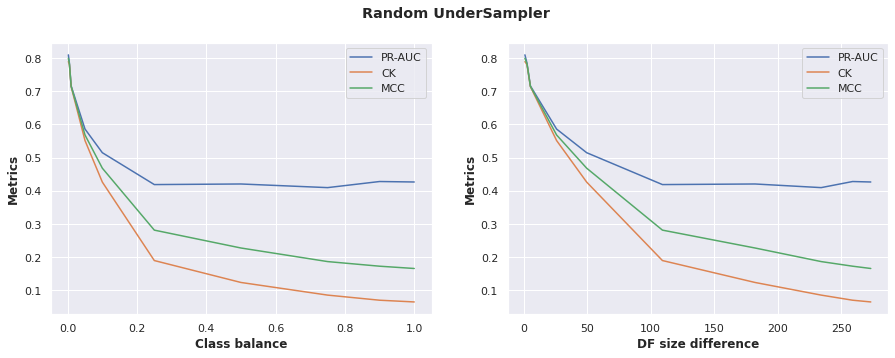

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(balance, prauc, label='PR-AUC')
axes[0].plot(balance, ck, label='CK')
axes[0].plot(balance, mcc, label='MCC')
axes[0].set_xlabel('Class balance', weight='bold')
axes[0].set_ylabel('Metrics', weight='bold')
axes[0].legend()

axes[1].plot(ds_size, prauc, label='PR-AUC')
axes[1].plot(ds_size, ck, label='CK')
axes[1].plot(ds_size, mcc, label='MCC')
axes[1].set_xlabel('DF size difference', weight='bold')
axes[1].set_ylabel('Metrics', weight='bold')
axes[1].legend()
fig.suptitle('Random UnderSampler', weight='bold') # check l8r

На мой взгляд, эти графики очень хорошо иллюстрируют идею о том, что с уменьшением размера обучающей выборки (а выборка уменьшается, поскольку мы выбрасываем наблюдения мажорного класса), у нас падает качество. 

Поэтому лучшие значения метрик качества получились на тех параметрах, где выборка уменьшается незначительно. 

Так как у нас параметры баланс классов и отношение размеров выборок связаны между собой, графики получились примерно одинаковые, со слегка различающимся масштабом. 

До баланса 0.25 качество падает быстрее, после 0,25 выходит на плато. 



Даже такой наивный подход может дать относительно неплохие результаты и улучшить наши метрики. Тем не менее, сейчас мы никак не используем информацию о распределении объектов в выборке. Оказывается, что даже относительно простые эвристические правила могут заметно поднять нам качество - например, мы можем при отбрасывании использовать близость отдельных объектов мажорного класса к минорному и отбрасывать самые близкие. Протестируйте алгоритм [Near-Miss](https://www.site.uottawa.ca/~nat/Workshop2003/jzhang.pdf) на наших данных и постройте графики, аналогичные предыдущему пункту (также добавьте график с зависимостью качества от числа соседей).

In [48]:
from imblearn.under_sampling import NearMiss 

In [49]:
balance = [0.002, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 1]
ds_size=[]
ap = []
prauc = []
ck = []
mcc = []

for b in balance:
    
    sampler = NearMiss(sampling_strategy=b)
    X_res, y_res = sampler.fit_resample(X_train, y_train)
    ds_size.append(len(X_train)/len(X_res))
    
    model = CatBoostClassifier(iterations=1000, metric_period=100) 

    model.fit(X_res, y_res)
    y_pred = model.predict(X_test)
    y_true = y_test
    
    ap.append(average_precision_score(y_true, y_pred))
    prauc.append(pr_auc(y_true, y_pred))
    ck.append(cohen_kappa_score(y_true, y_pred))
    mcc.append(matthews_corrcoef(y_true, y_pred))
    
pd.DataFrame(data = {'Average Precision': ap, 'PR-AUC':prauc, 'Cohen-Kappa':ck, 'Matthews':mcc}, index=balance)

Learning rate set to 0.100824
0:	learn: 0.3818257	total: 68.2ms	remaining: 1m 8s
100:	learn: 0.0016139	total: 6.02s	remaining: 53.6s
200:	learn: 0.0011929	total: 11.9s	remaining: 47.5s
300:	learn: 0.0008782	total: 18s	remaining: 41.8s
400:	learn: 0.0006518	total: 24.4s	remaining: 36.4s
500:	learn: 0.0004728	total: 30.5s	remaining: 30.4s
600:	learn: 0.0003263	total: 36.9s	remaining: 24.5s
700:	learn: 0.0002342	total: 43.3s	remaining: 18.5s
800:	learn: 0.0001979	total: 49.3s	remaining: 12.2s
900:	learn: 0.0001979	total: 54.5s	remaining: 5.99s
999:	learn: 0.0001979	total: 59.7s	remaining: 0us
Learning rate set to 0.068265
0:	learn: 0.4932857	total: 32.2ms	remaining: 32.2s
100:	learn: 0.0038983	total: 3.08s	remaining: 27.4s
200:	learn: 0.0027692	total: 6.13s	remaining: 24.4s
300:	learn: 0.0021574	total: 9.2s	remaining: 21.4s
400:	learn: 0.0016424	total: 12.3s	remaining: 18.4s
500:	learn: 0.0012268	total: 15.4s	remaining: 15.4s
600:	learn: 0.0009717	total: 18.5s	remaining: 12.3s
700:	learn:

,Average Precision,PR-AUC,Cohen-Kappa,Matthews
0.002,0.495230,0.707211,0.699791,0.703322
0.005,0.465122,0.681941,0.681572,0.681572
0.010,0.200781,0.488091,0.410322,0.447208
0.050,0.007730,0.391339,0.017809,0.082640
0.100,0.006476,0.390528,0.014630,0.074668
0.250,0.010038,0.392833,0.023627,0.095596
0.500,0.011318,0.393661,0.026834,0.102074
0.750,0.011925,0.394054,0.028352,0.105012
0.900,0.013017,0.394760,0.031071,0.110088
1.000,0.011529,0.393798,0.027363,0.103108


Получилось хуже, чем на Random UnderSampling и даже хуже, чем на бейзлайне.

Text(0.5, 0.98, 'Near Miss')

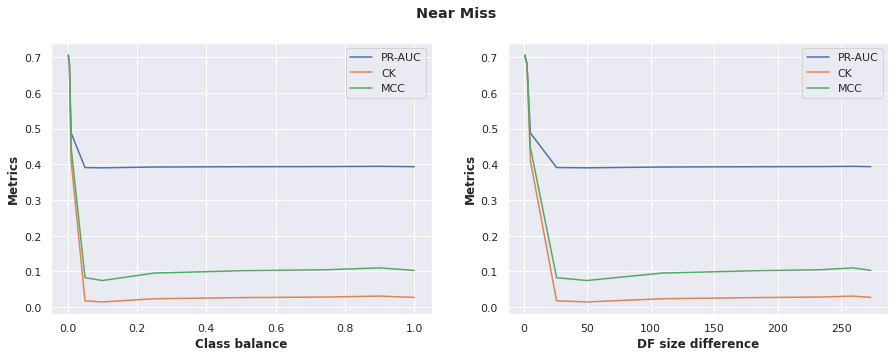

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(balance, prauc, label='PR-AUC')
axes[0].plot(balance, ck, label='CK')
axes[0].plot(balance, mcc, label='MCC')
axes[0].set_xlabel('Class balance', weight='bold')
axes[0].set_ylabel('Metrics', weight='bold')
axes[0].legend()

axes[1].plot(ds_size, prauc, label='PR-AUC')
axes[1].plot(ds_size, ck, label='CK')
axes[1].plot(ds_size, mcc, label='MCC')
axes[1].set_xlabel('DF size difference', weight='bold')
axes[1].set_ylabel('Metrics', weight='bold')
axes[1].legend()
fig.suptitle('Near Miss', weight='bold')

In [51]:
balance = [0.002, 0.02, 0.2]
neighbors = [1,2,5,7,10,15,25,50]
ap = []
prauc = []
ck = []
mcc = []

for b in balance:
    for n in neighbors:
    
        sampler = NearMiss(sampling_strategy=b, n_neighbors=n)
        X_res, y_res = sampler.fit_resample(X_train, y_train)
    
        model = CatBoostClassifier(iterations=500, metric_period=100) 

        model.fit(X_res, y_res)
        y_pred = model.predict(X_test)
        y_true = y_test
    
        prauc.append(pr_auc(y_true, y_pred))
        ck.append(cohen_kappa_score(y_true, y_pred))
        mcc.append(matthews_corrcoef(y_true, y_pred))

Learning rate set to 0.190374
0:	learn: 0.2146212	total: 68ms	remaining: 33.9s
100:	learn: 0.0011697	total: 6.29s	remaining: 24.9s
200:	learn: 0.0006539	total: 12.6s	remaining: 18.8s
300:	learn: 0.0003158	total: 19s	remaining: 12.6s
400:	learn: 0.0001812	total: 25.1s	remaining: 6.21s
499:	learn: 0.0001128	total: 31.3s	remaining: 0us
Learning rate set to 0.190374
0:	learn: 0.2143191	total: 69.5ms	remaining: 34.7s
100:	learn: 0.0012244	total: 6.14s	remaining: 24.3s
200:	learn: 0.0007047	total: 12.1s	remaining: 18s
300:	learn: 0.0003711	total: 18.2s	remaining: 12s
400:	learn: 0.0001931	total: 24.3s	remaining: 6s
499:	learn: 0.0001295	total: 30.4s	remaining: 0us
Learning rate set to 0.190374
0:	learn: 0.2147924	total: 70.6ms	remaining: 35.2s
100:	learn: 0.0012470	total: 6.33s	remaining: 25s
200:	learn: 0.0007011	total: 12.8s	remaining: 19s
300:	learn: 0.0003741	total: 19s	remaining: 12.6s
400:	learn: 0.0001860	total: 25.3s	remaining: 6.24s
499:	learn: 0.0001253	total: 31.4s	remaining: 0us


In [52]:
# это просто вспомогательный вывод, можно проигнорить
pd.DataFrame(data = {'PR-AUC':prauc, 'Cohen-Kappa':ck, 'Matthews':mcc})

,PR-AUC,Cohen-Kappa,Matthews
0,0.730087,7.177587e-01,0.723739
1,0.757699,7.498261e-01,0.753609
2,0.686743,6.826997e-01,0.684537
3,0.755822,7.366708e-01,0.746041
4,0.707211,6.997913e-01,0.703322
5,0.755822,7.366708e-01,0.746041
6,0.763742,7.617295e-01,0.762596
7,0.707211,6.997913e-01,0.703322
8,0.446216,2.679858e-01,0.345456
9,0.414375,1.766613e-01,0.270166


Я не люблю плохо интерпретируемые графики, и в этом задании как раз есть риск на такое наткнуться из-за того, что мы хотим иллюстрировать одновременно много всего: три метрики, различный баланс классов и различное количество соседей. 

Поэтому я решила приоритизировать информацию, которую я хочу видеть на графиках. Во-первых, не будем рисовать зависимость от соотношения размеров выборки, так как она дублирует параметр баланс классов. В этом задании важнее всего посмотреть как меняется качество от количества соседей, поэтому их изобразим на горизонтальной оси. Баланс классов будем различать разными цветами на одном графике. При этом я взяла только три значения баланса, так как они наиболее интересные/информативные. Для бОльших значений метрики уходят в 0 (типа случайный классификатор). 

Text(0.5, 0.98, 'Near Miss')

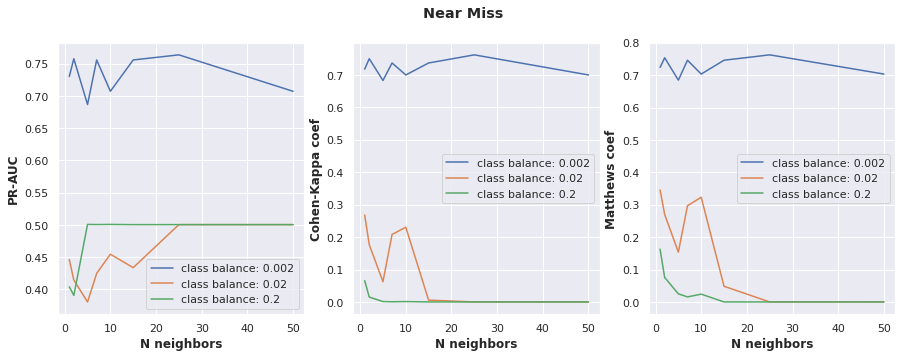

In [53]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(neighbors, prauc[0:8], label='class balance: 0.002')
axes[0].plot(neighbors, prauc[8:16], label='class balance: 0.02')
axes[0].plot(neighbors, prauc[16:24], label='class balance: 0.2')
axes[0].set_xlabel('N neighbors', weight='bold')
axes[0].set_ylabel('PR-AUC', weight='bold')
axes[0].legend()

axes[1].plot(neighbors, ck[0:8], label='class balance: 0.002')
axes[1].plot(neighbors, ck[8:16], label='class balance: 0.02')
axes[1].plot(neighbors, ck[16:24], label='class balance: 0.2')
axes[1].set_xlabel('N neighbors', weight='bold')
axes[1].set_ylabel('Cohen-Kappa coef', weight='bold')
axes[1].legend()

axes[2].plot(neighbors, mcc[0:8], label='class balance: 0.002')
axes[2].plot(neighbors, mcc[8:16], label='class balance: 0.02')
axes[2].plot(neighbors, mcc[16:24], label='class balance: 0.2')
axes[2].set_xlabel('N neighbors', weight='bold')
axes[2].set_ylabel('Matthews coef', weight='bold')
axes[2].legend()

fig.suptitle('Near Miss', weight='bold')

Ну вот, получилось не то, чтобы очень красиво, но более менее интерпретируемо. Здесь видно, что хорошее качество только для баланса классов 0.002. 

Нарисую отдельно зависимость метрик от числа соседей на балансе 0.002.

In [54]:
neighbors = [1,2,5,7,10,12,15,25]
ap = []
prauc = []
ck = []
mcc = []

for n in neighbors:
    
    sampler = NearMiss(sampling_strategy=0.002, n_neighbors=n)
    X_res, y_res = sampler.fit_resample(X_train, y_train)
    
    model = CatBoostClassifier(iterations=500, metric_period=100) 

    model.fit(X_res, y_res)
    y_pred = model.predict(X_test)
    y_true = y_test
    
    prauc.append(pr_auc(y_true, y_pred))
    ck.append(cohen_kappa_score(y_true, y_pred))
    mcc.append(matthews_corrcoef(y_true, y_pred))
    
pd.DataFrame(data = {'PR-AUC':prauc, 'Cohen-Kappa':ck, 'Matthews':mcc})

Learning rate set to 0.190374
0:	learn: 0.2146212	total: 69.5ms	remaining: 34.7s
100:	learn: 0.0011697	total: 5.81s	remaining: 23s
200:	learn: 0.0006539	total: 11.5s	remaining: 17.1s
300:	learn: 0.0003158	total: 17.3s	remaining: 11.4s
400:	learn: 0.0001812	total: 23s	remaining: 5.69s
499:	learn: 0.0001128	total: 28.7s	remaining: 0us
Learning rate set to 0.190374
0:	learn: 0.2143191	total: 69.3ms	remaining: 34.6s
100:	learn: 0.0012244	total: 5.75s	remaining: 22.7s
200:	learn: 0.0007047	total: 11.5s	remaining: 17.1s
300:	learn: 0.0003711	total: 17.2s	remaining: 11.4s
400:	learn: 0.0001931	total: 23.1s	remaining: 5.7s
499:	learn: 0.0001295	total: 28.8s	remaining: 0us
Learning rate set to 0.190374
0:	learn: 0.2147924	total: 66.8ms	remaining: 33.3s
100:	learn: 0.0012470	total: 5.72s	remaining: 22.6s
200:	learn: 0.0007011	total: 11.4s	remaining: 17s
300:	learn: 0.0003741	total: 17.2s	remaining: 11.4s
400:	learn: 0.0001860	total: 23s	remaining: 5.69s
499:	learn: 0.0001253	total: 28.8s	remaini

,PR-AUC,Cohen-Kappa,Matthews
0,0.730087,0.717759,0.723739
1,0.757699,0.749826,0.753609
2,0.686743,0.682700,0.684537
3,0.755822,0.736671,0.746041
4,0.707211,0.699791,0.703322
5,0.782208,0.769075,0.775483
6,0.755822,0.736671,0.746041
7,0.763742,0.761729,0.762596


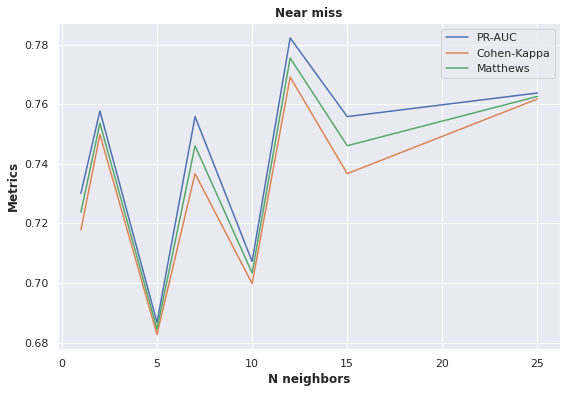

In [55]:
plt.plot(neighbors, prauc, label='PR-AUC')
plt.plot(neighbors, ck, label='Cohen-Kappa')
plt.plot(neighbors, mcc, label='Matthews')
plt.xlabel('N neighbors', weight='bold')
plt.ylabel('Metrics', weight='bold')
plt.title('Near miss', weight='bold')
plt.legend()

Метрики ведут себя почти одинаково :)

Оптимальное число соседей 12

Text(0.5, 0.98, 'Near Miss')

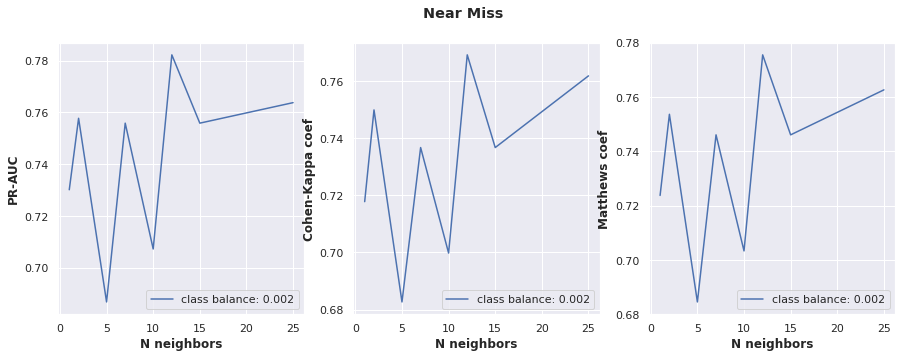

In [56]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(neighbors, prauc, label='class balance: 0.002')
axes[0].set_xlabel('N neighbors', weight='bold')
axes[0].set_ylabel('PR-AUC', weight='bold')
axes[0].legend()

axes[1].plot(neighbors, ck, label='class balance: 0.002')
axes[1].set_xlabel('N neighbors', weight='bold')
axes[1].set_ylabel('Cohen-Kappa coef', weight='bold')
axes[1].legend()

axes[2].plot(neighbors, mcc, label='class balance: 0.002')
axes[2].set_xlabel('N neighbors', weight='bold')
axes[2].set_ylabel('Matthews coef', weight='bold')
axes[2].legend()

fig.suptitle('Near Miss', weight='bold')

Это то же самое, только расщеплено на три графика. Можно проигнорировать, мне просто было жалко удалять))

**Бонус (1 балл)**. imblearn также предлагает много различных методов для андерсэмплинга. Выберите что-нибудь еще из предлагаемого на свой вкус, опишите идею метода и протестируйте его.

**Бонус (2 балла)**. Сможете ли вы с помощью комбинации любых методов оверсэмплинга, андерсэмплинга и классификации набрать 0.8 на всех трех метриках?

In [31]:
from imblearn.under_sampling import ClusterCentroids 

Мне кажется интересным метод Cluster Centroids. Давайте потестим его.
Идея метода заключается в том, что объекты мажорного класса кластеризуются (количество кластеров - столько, сколько мы хотим оставить наблюдений мажорного класса). Затем объекты заменяются на центроиды своих кластеров.

Кластризация - K-Means.

https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.ClusterCentroids.html 

In [35]:
sampler = ClusterCentroids(sampling_strategy=1, random_state=690) # trained 5 minuites due to clustering 
X_res, y_res = sampler.fit_resample(X_train, y_train)
    
model = CatBoostClassifier(iterations=1000, metric_period=100) 

model.fit(X_res, y_res)
y_pred = model.predict(X_test)
y_true = y_test

print('\nAverage precision:', average_precision_score(y_true, y_pred), 
      '\nPR-AUC:', pr_auc(y_true, y_pred),
      '\nCohen-Kappa coefficient:', cohen_kappa_score(y_true, y_pred),
      '\nMatthews coeficient:', matthews_corrcoef(y_true, y_pred))

Learning rate set to 0.009534
0:	learn: 0.6737423	total: 22.3ms	remaining: 22.3s
100:	learn: 0.0695662	total: 963ms	remaining: 8.57s
200:	learn: 0.0211086	total: 1.86s	remaining: 7.39s
300:	learn: 0.0108915	total: 2.79s	remaining: 6.48s
400:	learn: 0.0070679	total: 3.72s	remaining: 5.56s
500:	learn: 0.0050281	total: 4.6s	remaining: 4.58s
600:	learn: 0.0038330	total: 5.47s	remaining: 3.63s
700:	learn: 0.0030176	total: 6.38s	remaining: 2.72s
800:	learn: 0.0023256	total: 7.32s	remaining: 1.82s
900:	learn: 0.0017927	total: 8.24s	remaining: 905ms
999:	learn: 0.0014149	total: 9.15s	remaining: 0us

Average precision: 0.0009859723031416664 
PR-AUC: 0.5004929861515708 
Cohen-Kappa coefficient: 0.0004272938526913572 
Matthews coeficient: 0.014618227700678575


Результат: поскольку здесь задействован алгоритм кластеризации, эта штука долго учится. При этом чем больше объектов мажорного класса мы хотим оставить, тем дольше она будет учиться (поэтому для теста я выбрала такой параметр sampling strategy, чтобы получить соотношение классов 1:1). 

Таким образом, мы потеряли кучу информации, так как удалили кучу объектов мажорного класса и качество получилось таким поганым)) 

(здесь должен быть мем с плачущим котенком который делает большой палец вверх)

Хочется сделать вывод, что хоть этот метод идейно прикольнее, чем просто рандомно удалять объекты из выборки, но наверное для больших выборок он не очень подходит и учится долго.

Бонус 2

In [39]:
# пробовала вот такую комбинацию, но забила потому что долго 
from imblearn.combine import SMOTEENN 

sampler = SMOTEENN(sampling_strategy=0.002, random_state=123) 
X_res, y_res = sampler.fit_resample(X_train, y_train)
    
model = CatBoostClassifier(iterations=1000, metric_period=100) 

model.fit(X_res, y_res)
y_pred = model.predict(X_test)
y_true = y_test

print('\nAverage precision:', average_precision_score(y_true, y_pred), 
      '\nPR-AUC:', pr_auc(y_true, y_pred),
      '\nCohen-Kappa coefficient:', cohen_kappa_score(y_true, y_pred),
      '\nMatthews coeficient:', matthews_corrcoef(y_true, y_pred))

KeyboardInterrupt: ignored

In [41]:
from imblearn.under_sampling import RandomUnderSampler 

In [57]:
#smote = SVMSMOTE(sampling_strategy=0.002, random_state=690)
#X_res, y_res = smote.fit_resample(X_train, y_train)

us = RandomUnderSampler(sampling_strategy=0.002, random_state=690) # hyperparameters change here
X_res, y_res = us.fit_resample(X_train, y_train)
    
model = CatBoostClassifier(iterations=1000, l2_leaf_reg=5, metric_period=100, target_border=0.1) # hyperparameters change here

model.fit(X_res, y_res)
y_pred = model.predict(X_test)
y_true = y_test

print('\nAverage precision:', average_precision_score(y_true, y_pred), 
      '\nPR-AUC:', pr_auc(y_true, y_pred),
      '\nCohen-Kappa coefficient:', cohen_kappa_score(y_true, y_pred),
      '\nMatthews coeficient:', matthews_corrcoef(y_true, y_pred))

0:	learn: 0.5870348	total: 72.4ms	remaining: 1m 12s
100:	learn: 0.0026456	total: 5.91s	remaining: 52.6s
200:	learn: 0.0021094	total: 11.6s	remaining: 46s
300:	learn: 0.0018602	total: 17.2s	remaining: 39.9s
400:	learn: 0.0016829	total: 22.8s	remaining: 34.1s
500:	learn: 0.0015511	total: 28.3s	remaining: 28.2s
600:	learn: 0.0014590	total: 34s	remaining: 22.6s
700:	learn: 0.0013707	total: 39.5s	remaining: 16.8s
800:	learn: 0.0012938	total: 45.1s	remaining: 11.2s
900:	learn: 0.0012170	total: 50.8s	remaining: 5.58s
999:	learn: 0.0011572	total: 56.4s	remaining: 0us

Average precision: 0.6394503233415578 
PR-AUC: 0.809781979852597 
Cohen-Kappa coefficient: 0.7893366519535417 
Matthews coeficient: 0.7993772213060292


Лучшие результаты so far получились вот на таких параметрах (Это просто Random UnderSampler с маленьким балансом классов.)

# Часть 2. Поиск аномалий. 

Как вы могли заметить, методы балансировки выборок очень часто могут привести к не самым лучшим результатам из-за того, что они по сути искажают информацию о реальном распределении данных - в реальности обычно требуется долгий подбор в принципе работоспособных для задачи методов и их аккуратная настройка. 

Теперь давайте попробуем слегка сменить постановку задачи и переключиться на задачу "одноклассовой" классификации, то есть - поиска *аномалий* в выборке. В общем-то, это вполне согласуется с нашей областью работы - мы действительно можем назвать мошеннические транзакции аномальньми (как интуитивно, так и на основании наблюдаемой балансировки данных). 

Стоит отметить, что методы обнаружения аномалий чаще всего относятся к классу методов обучения без учителя. Это дает некоторый положительный эффект - нам не обязательно нужно тратить время на разметку данных (тем не менее, для контроля качества какую-то часть разметить все-таки придется). Впрочем, чаще всего перфоманс таких методов оказывается заметно хуже, чем у честного обучения с учителем (если мы можем себе его позволить).



**Задание 4. (3 балла).** На занятиях вы разбирали схожий с Random Forest подход для детекции аномалий без известной разметки данных, называемый Isolation Forest. Напомним суть: на этапе обучения мы создаем ансамбль из решающих деревьев, в котором признак и порог на каждую вершину подбираются случайно. Затем мы считаем для объектов оценку аномальности через длину пути до соответствующего листа в каждом дереве.

В данном задании вам предлагается реализовать модификацию данного алгоритма, известную как Extended Isolation Forest. В ней мы на каждом шаге будем определять не порог для признака, а полноценную случайную гиперплоскость, разбивающую выборку на 2 части. С детальным описанием вы можете ознакомиться [здесь](https://arxiv.org/pdf/1811.02141.pdf).

Ниже приведен шаблон кода. Постарайтесь работать в его рамках (минорные изменения вполне допустимы, главное не переворачивайте всю структуру с ног на голову). 

**NB**: будем считать, что в нашем датасете нет категориальных признаков - можете не заморачиваться с их обработкой (но в общем случае, это будет важно).

**Советы**:
 - Численные признаки лучше предобработать надлежащим образом.
 - Возможно, вам поможет выбрасывание некоторых признаков.
 - Внимательно следите за знаками.
 - Не игнорируйте документирующие строки.
 - Вероятнее всего, вы не сможете приблизиться по качеству к supervised-решениям. Если у вас не получается это сделать (но вы уверены в своей правоте), не стоит тратить слишком много времени на поиск ошибок.



**Бонусы (каждый по 0.5)**:
- Сделайте ваш EIF параллельным (`multiprocessing`, `joblib`).
- Добавьте возможность откатиться к дефолтному варианту Isolation Forest. (порассуждайте, как можно реализовать это в данной модели?):


In [ ]:
def c_factor(n):
    """
    Computes average path length for an unsuccessful search in a binary search tree.
    Params:
        n: int - number of data points for BST
    """
    #your code here

def calc_height(X, depth, node):
    """
    Calculates anomaly scores for sample in a recursive manner.
    Params:
        X: np.array - current sample, available to node
        
        depth: int - path length up to current node
        
        node: Node - current tree node
        
    Returns:
        scores: int, float or np.array - anomaly scores for sample
    """
    scores = np.zeros(X.shape[0])

    #your code here


class Node(object):
    """
    A single node object for each tree. Contains information on height, current data,
    splitting hyperplane and children nodes.
    
    Attributes:
        X: np.array - data available to current node
        size: int - length of available data
        
        depth: int - depth of node

        left: Node - left child
        right: Node - right child

        kind: str - either "internal" or "external", indicates the type of current node

        w: np.array - normal vector for the splitting hyperplane
        b: float - intercept term for the splitting hyperplane
    """
    def __init__(self, X, depth, left, right, kind, w, b):
        """
        Node(h, left, right, kind, w, b)
        Represents the node object.
        
        Params:
            X: np.array - data available to current node
            depth: int - depth of node
            
            left: Node - left child
            right: Node - right child
            
            kind: str - either "internal" or "external", indicates the type of current node
            
            w: np.array - normal vector for the splitting hyperplane
            b: float - intercept term for the splitting hyperplane
            
        """
        self.size = len(X)
        
        self.depth = depth
        
        self.left = left
        self.right = right
        
        self.kind = kind
    
        self.w = w
        self.b = b
    
    def __repr__(self):
        """
        For convenience only.
        """
        return f"Node(size={self.size}, depth={self.depth}, kind={self.kind})"

class RandomizedTree(object):
    """
    Single randomized tree object. Stores root and its depth (tree is built recursively).
    Attributes:
        depth: int - current tree depth
        
        max_depth: int - maximum tree depth
        
        root: Node - root node 

        internal_count: int - number of internal nodes

        external_count: int - number of external nodes
        
    """
    def __init__(self, X, max_depth):
        """
        Single randomized tree object. Stores root and its depth (tree is built recursively).
        Params:
            X: np.array - train sample
            max_depth: int - maximum tree depth

        """
        self.depth = 0
        self.max_depth = max_depth
        
        self.internal_count = 0
        self.external_count = 0

        self.root = self.grow(X, 0)
        
    def __repr__(self):
        """
        For convenience only.
        """
        
        return f"RandomizedTree(depth={self.depth}, max_depth={self.max_depth}, n_internal={self.internal_count}, n_external={self.external_count})"

        
        
    def grow(self, X, depth):
        """
        Grow tree in a recursive manner.
        Params:
            X: np.array - available train sample
            
            depth: int - current tree depth
            
        Returns:
            node: Node - a trained node with separating hyperplane data.
                         Node provides access to children if necessary (these are built recursively)
        """
        #your code here
            
        return Node(X, depth, left, right, kind, w, b)

    def score_samples(self, X):
        """
        Calculate anomaly scores for given data. You may utilize outer function `calc_height`.
        Params:
            X: np.array - data to be evaluated
            
        Returns:
            scores: np.array - estimated anomaly scores
        """
        #your code here

        return scores
        
    
class ExtendedIsolationForest(object):
    """
    Extended Isolation Forest object. Stores training data and trained randomized trees.
    Attributes:
        n_trees: int - number of Randomized Trees
        
        max_depth: int - maximum depth of each tree
        
        subsample_rate: float - draw `subsample_rate * X.shape[0]` samples for each tree
        
        trees: list - container for trained trees 
        
        contamination: float - estimated fraction of anomaly samples in data. Used for thresholding
        
    """
    
    def __init__(self, n_trees, subsample_rate, max_depth=None, contamination=0.01):
        """
        Extended Isolation Forest object. Stores training data and trained randomized trees.
        Params:
            n_trees: int - number of Randomized Trees

            subsample_rate: float - draw `subsample_rate * X.shape[0]` samples for each tree

            max_depth: int or None - maximum depth of each tree. Defaults to ceil(log_2(subsample_size)) if not provided

            contamination: float - estimated fraction of anomaly samples in data. Used for thresholding

        """
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.subsample_rate = subsample_rate
        self.trees = []
        self.contamination = contamination
        self.is_fit = False
        
    def __repr__(self):
        """For convenience only."""
        
        return f"ExtendedIsolationForest(n_trees={self.n_trees}, max_depth={self.max_depth}, subsample_rate={self.subsample_rate}, contamination={self.contamination}, is_fit={self.is_fit})"
        
    def fit(self, X):
        """
        Fit EIF to new data.
        Params:
            X: np.array - 2d array of samples
        """
        #your code here
        return self
    
    def score_samples(self, X):
        """
        Estimate (normalized) anomaly score for each given sample
        Params:
            X: np.array - new samples

        Returns:
            scores: np.array - anomaly scores (larger value means higher probability of a sample being an outlier)
        """
        #your code here

        return scores

    
    def predict(self, X):
        """
        Predict if given samples are outliers.
        Params:
            X: np.array - new samples

        Returns:
            labels: np.array - anomaly labels (1 for outliers, 0 for inliers)
        """
        #your code here

        return labels


Написать этот код руками: миссия невыполнима, поэтому импортирую библиотеку индуса, чтобы были все дальнейшие решения заданий - особенно, там где нужно сравнивать алгоритмы.

In [82]:
#!pip install eif
# for colab imports

     |████████████████████████████████| 1.6 MB 5.3 MB/s 
  Created wheel for eif: filename=eif-2.0.2-cp37-cp37m-linux_x86_64.whl size=251334 sha256=f561727399fd6fd2f89f9cac10506cf05aa7448d496f3013130bde8fd88a42f9
  Stored in directory: /root/.cache/pip/wheels/99/2d/aa/26b73ee1302b1967b90ea1dfa3ba78bcbcee9916a028a7bba5
Successfully built eif


**Задание 5. (1 балл).** Протестируйте вашу реализацию EIF и подберите оптимальные гиперпараметры (наш метод не использует разметку, поэтому можете попробовать делать это на обучающей выборке). Сравните ее с обычным IF из `sklearn` (желательно делать это на одних и тех же параметрах). Удалось ли сделать лучше?

In [58]:
import eif
eif.__version__

'2.0.2'

In [59]:
X_train = X_train.to_numpy()
X_val = X_val.to_numpy()
X_test = X_test.to_numpy()

In [60]:
model  = eif.iForest(X_train, ntrees=500, sample_size=256, ExtensionLevel=1)
eif_train_scores = model.compute_paths(X_in=X_train)
eif_train_scores

array([0.43625421, 0.41097063, 0.506643  , ..., 0.53483164, 0.39984578,
       0.38889207])

Результатом обучения этой модели является массив из скоров, которые показывают оценку аномальности объектов. Чем больше скор - тем более аномальным мы считаем объект. 

Давайте посмотрим как это выглядит и что из этого можно слепить. 
Ниже я сортирую объекты из обучающей выборки по оценкам аномальности, которые для них выдала модель. Дальше я беру последние 100 наблюдений из этого отсортированного массива.

In [61]:
ind = np.argsort(eif_train_scores)
y_train_anomalysorted = y_train[ind]
y_train_anomalysorted[-100:]

10630     1
153851    0
76679     0
211449    0
206783    0
201638    0
217781    0
98469     0
42945     1
219530    0
10891     1
150678    1
150677    1
217533    0
100954    0
8610      0
150667    1
150666    1
90946     0
42936     1
150680    1
150679    1
212950    0
190088    0
48955     0
24633     0
219776    0
151011    1
56335     0
151462    1
43160     1
151519    1
175710    0
44223     1
150668    1
150669    1
158499    0
152295    1
65423     0
6812      0
152223    1
42294     0
44513     0
15364     0
217409    0
184433    0
110467    0
168402    0
153835    1
37000     0
43428     1
110249    0
151006    1
151007    1
151009    1
151008    1
201869    0
154234    1
118764    0
145022    0
43204     1
170007    0
10690     1
224569    0
50287     0
104967    0
220212    0
23128     0
218985    0
188560    0
108424    0
131480    0
110608    0
1632      0
154587    1
154371    1
226690    0
153823    1
154684    1
201775    0
199847    0
121787    0
169457    0
4684

Здесь можно увидеть, что единички встречаются достаточно часто. (учитывая соотношение классов - это часто)

А мы как раз вывели 100 объектов которые модель считает самыми аномальными. 

Теперь можно посмотреть на распределение скоров. 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


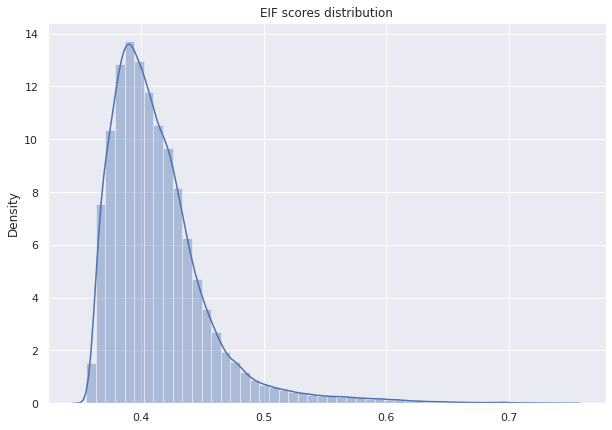

In [62]:
plt.figure(figsize=(10,7))
sns.distplot(eif_train_scores, kde=True, color="b")
plt.title('EIF scores distribution')

plt.show()

Тоже нормальный (хаха) результат для модели - высокие скоры встречаются намного реже в выборке, что свидетельствует о том, что модель считает, что аномальных объектов в выборке относительно немного, а нормальных много.

идея: https://github.com/sahandha/eif/blob/master/Notebooks/EIF.ipynb 

Как пишут представители библиотеки: 

The distribution of anomaly scores are shown. By definition, anomalies are those that occur less frequently. So it makes sense that the number of points with higher anomaly scores reduces as the score increases.

Поскольку, если я правильно поняла, эта библиотека умеет оценивать скоры, но не умеет делать предикт, можно сделать предикт самостоятельно. 

Я делаю это таким образом: определяю порог бинаризации, при превышении которого в скорах (которые выдает модель) объект будет считаться аномальным. Так можно регулировать с помощью порога, а можно было еще прикрутить параметр, который отвечает за то, какой процент объектов выборки мы хотим считать аномальными. 

Порог, как мне кажется, можно определить вручную или с помощью перебора на валидации. 

In [63]:
def eif_predict_class(anomaly_scores, border): # можно попробовать настроить Border на валидационной
    y_pred = []
    a = 0 
    for i in anomaly_scores:
        if i >= border:
            a = 1
        else: 
            a = 0
        y_pred.append(a)
    return np.array(y_pred)

In [64]:
eif_predict_class(eif_train_scores, 0.5).shape

(227845,)

Задаем порог 0.5 (Можно сказать, например так: мы посмотрели на график распределения скоров и решили скоры больше 0.5 считать аномальными, поскольку на распределении там совсем тяжелый хвост, в который попадает очень мало объектов).

Не знаю, насколько хорошей идеей в этой части задания считать метрики из первой части, поскольку задача поиска аномалий является задачей обучения без учителя и по классике в ней нет меток и нужно считать качество как-то по другому, и оптимизировать тоже по другому. 

Ну давайте, раз уж (теперь) все эти методы делают предикт, а мы знаем метки классов + нам нужно сравнивать методы между собой, будем считать метрики. Но, на мой взгляд, это как-то мутно все же...

In [65]:
y_pred = eif_predict_class(eif_train_scores, 0.5)
y_true = y_train

print('\nTrain',
      '\nAverage precision:', average_precision_score(y_true, y_pred), 
      '\nPR-AUC:', pr_auc(y_true, y_pred),
      '\nCohen-Kappa coefficient:', cohen_kappa_score(y_true, y_pred),
      '\nMatthews coeficient:', matthews_corrcoef(y_true, y_pred))


Train 
Average precision: 0.03271487271437239 
PR-AUC: 0.4391248399158534 
Cohen-Kappa coefficient: 0.0706029687653259 
Matthews coeficient: 0.1752027536153829


Поскольку предикт для EIF мы определили вручную, можно считать target_border за гиперпараметр. (остальные гиперпараметры, на мой взгляд не так интересны: количество деревьев, размер подвыборки и параметр который отвечает за то, будем мы применять обычный Isolation Forest или Extended его версию).
Поэтому на валидационной выборке найдем такой порог бинаризации, который будет давать большее значение метрики качества (я выбрала MCC) и посчитаем значение метрик на тесте.

In [66]:
model  = eif.iForest(X_train, ntrees=500, sample_size=256, ExtensionLevel=1) 
val_scores = model.compute_paths(X_in=X_val)
mcc_scores=[]

borders = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for b in borders:
  y_pred = eif_predict_class(val_scores, b)
  y_true = y_val
  mcc = matthews_corrcoef(y_true, y_pred)
  mcc_scores.append(mcc)
  
best_b = borders[np.argmax(np.array(mcc_scores))]
print('\nBest validation score:', max(mcc_scores), 
      '\nBest target border:', best_b)


Best validation score: 0.15877028732245146 
Best target border: 0.6


Сравним теперь результаты предиктов с порогами 0.5 и 0.6.

In [67]:
eif_test_scores = model.compute_paths(X_in=X_test)
y_pred = eif_predict_class(eif_test_scores, 0.5)
y_true = y_test

print('\nTest 0.5',
      '\nAverage precision:', average_precision_score(y_true, y_pred), 
      '\nPR-AUC:', pr_auc(y_true, y_pred),
      '\nCohen-Kappa coefficient:', cohen_kappa_score(y_true, y_pred),
      '\nMatthews coeficient:', matthews_corrcoef(y_true, y_pred))


Test 0.5 
Average precision: 0.009715398506756488 
PR-AUC: 0.39262425368659937 
Cohen-Kappa coefficient: 0.022817173927091927 
Matthews coeficient: 0.09389427091906578


In [68]:
eif_test_scores = model.compute_paths(X_in=X_test)
y_pred = eif_predict_class(eif_test_scores, best_b)
y_true = y_test

print('\nTest 0.6',
      '\nAverage precision:', average_precision_score(y_true, y_pred), 
      '\nPR-AUC:', pr_auc(y_true, y_pred),
      '\nCohen-Kappa coefficient:', cohen_kappa_score(y_true, y_pred),
      '\nMatthews coeficient:', matthews_corrcoef(y_true, y_pred))


Test 0.6 
Average precision: 0.014989476818096217 
PR-AUC: 0.18208151526855224 
Cohen-Kappa coefficient: 0.07829951976475658 
Matthews coeficient: 0.11858444555659377


Вывод: подбор порога реально работает! но только на метриках CK и MCC. Их значения на тесте при пороге 0,6 увеличились на 0,02-0,05. Значение метрики PR-AUC снизилось (сильно :( ). 

Теперь потестим дефолтный IF из sklearn

In [69]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(n_estimators=500, random_state=690).fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)


In [70]:
y_pred_train

array([ 1,  1,  1, ..., -1,  1,  1])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


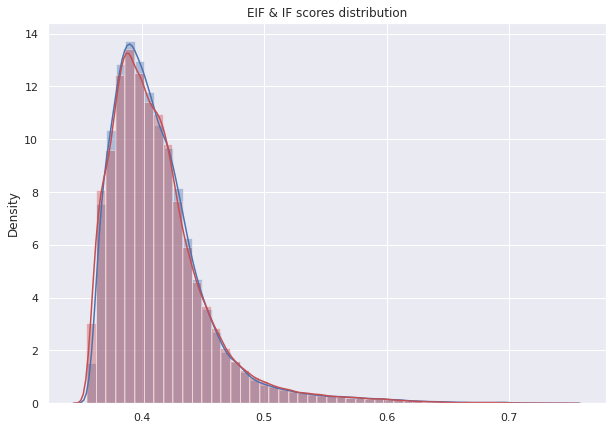

In [71]:
if_train_scores = clf.score_samples(X_train)*-1
if_test_scores = clf.score_samples(X_test)*-1

plt.figure(figsize=(10,7))
sns.distplot(eif_train_scores, kde=True, color="b")
sns.distplot(if_train_scores, kde=True, color="r")
plt.title('EIF & IF scores distribution')

plt.show()

В задании сказано сравнить EIF с обычным IF, поэтому я наложила гистограммы (распределение скоров для EIF И IF) друг на друга. ЧТо мы видим: гистограммы для обоих методов описывают примерно одинаковые распределения скоров. То есть оба метода оценивают аномалии примерно одинаково.

In [72]:
y_pred = y_pred_train
y_pred = np.where(y_pred==1, 0, y_pred)
y_pred = np.where(y_pred==-1, 1, y_pred)
y_true = y_train

print('\nTrain',
      '\nAverage precision:', average_precision_score(y_true, y_pred), 
      '\nPR-AUC:', pr_auc(y_true, y_pred),
      '\nCohen-Kappa coefficient:', cohen_kappa_score(y_true, y_pred),
      '\nMatthews coeficient:', matthews_corrcoef(y_true, y_pred))


Train 
Average precision: 0.03233718586761873 
PR-AUC: 0.44004491654137307 
Cohen-Kappa coefficient: 0.06959354159249442 
Matthews coeficient: 0.17412810400966897


In [73]:
y_pred = y_pred_test
y_pred = np.where(y_pred==1, 0, y_pred)
y_pred = np.where(y_pred==-1, 1, y_pred)
y_true = y_test

print('\nTest',
      '\nAverage precision:', average_precision_score(y_true, y_pred), 
      '\nPR-AUC:', pr_auc(y_true, y_pred),
      '\nCohen-Kappa coefficient:', cohen_kappa_score(y_true, y_pred),
      '\nMatthews coeficient:', matthews_corrcoef(y_true, y_pred))


Test 
Average precision: 0.01089037099766155 
PR-AUC: 0.3933845300042438 
Cohen-Kappa coefficient: 0.025765036258876495 
Matthews coeficient: 0.09995890377656731


Вывод: значения метрик оказались очень близкими (без подбора оптимальных гиперпараметров).

Мораль: можно не использовать библиотеку индусов.

Возможно, ваш алгоритм выдал большие оценки объектам с негативной разметкой. Постарайтесь выбрать несколько таких объектов и доступно объяснить (= с кодом и графиками), почему так вышло:

Думаю, потому что такие объекты оказалось легко отделить от всех остальных, путь до них оказался относительно коротким и им присвоили большие скоры. + возможно из-за рандома 

пжлст не ставьте ноль

**Задание 6. (1 балл).** `sklearn` также предлагает нам и другие методы для поиска аномалий. В этом задании мы предлагаем вам сделать следующее:

Для начала попробуйте использовать методы Local Outlier Factor и One-Class SVM. Сравните результаты с IF и EIF.  

In [102]:
from sklearn.neighbors import LocalOutlierFactor # trained 23 mins :с

clf = LocalOutlierFactor(n_neighbors=20)
y_pred_train = clf.fit_predict(X_train)

y_pred_train = np.where(y_pred_train==1, 0, y_pred_train)
y_pred_train = np.where(y_pred_train==-1, 1, y_pred_train)


print('\nTrain',
      '\nAverage precision:', average_precision_score(y_train, y_pred_train), 
      '\nPR-AUC:', pr_auc(y_train, y_pred_train),
      '\nCohen-Kappa coefficient:', cohen_kappa_score(y_train, y_pred_train),
      '\nMatthews coeficient:', matthews_corrcoef(y_train, y_pred_train))


Train 
Average precision: 0.005246710011584074 
PR-AUC: 0.10539806257189906 
Cohen-Kappa coefficient: 0.032753632700021296 
Matthews coeficient: 0.05623724368471665


In [106]:
lof_train_scores = clf.negative_outlier_factor_*-1
lof_train_scores

array([1.50991882, 1.35540632, 1.98923719, ..., 1.16372869, 1.44728167,
       1.18691986])

In [107]:
clf = LocalOutlierFactor(n_neighbors=20, novelty=True).fit(X_train)
y_pred_test = clf.predict(X_test)

y_pred_test = np.where(y_pred_test==1, 0, y_pred_test)
y_pred_test = np.where(y_pred_test==-1, 1, y_pred_test)
lof_test_scores = clf.negative_outlier_factor_*-1

print('\nTest',
      '\nAverage precision:', average_precision_score(y_test, y_pred_test), 
      '\nPR-AUC:', pr_auc(y_test, y_pred_test),
      '\nCohen-Kappa coefficient:', cohen_kappa_score(y_test, y_pred_test),
      '\nMatthews coeficient:', matthews_corrcoef(y_test, y_pred_test))


Test 
Average precision: 0.000772444787753239 
PR-AUC: 0.5003862223938766 
Cohen-Kappa coefficient: 0.0 
Matthews coeficient: 0.0


Local Outlier Factor: хуже, чем EIF и IF. 

На тестовой выборке вообще выдает результаты случайного классификатора.

In [19]:
from sklearn.svm import OneClassSVM

clf = OneClassSVM(kernel='linear').fit(X_train) # trained for 1 hour 
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

y_pred_train = np.where(y_pred_train==1, 0, y_pred_train)
y_pred_train = np.where(y_pred_train==-1, 1, y_pred_train)

y_pred_test = np.where(y_pred_test==1, 0, y_pred_test)
y_pred_test = np.where(y_pred_test==-1, 1, y_pred_test)

ocsvm_train_scores = clf.score_samples(X_train)*-1
ocsvm_test_scores = clf.score_samples(X_test)*-1

print('\nTrain',
      '\nAverage precision:', average_precision_score(y_train, y_pred_train), 
      '\nPR-AUC:', pr_auc(y_train, y_pred_train),
      '\nCohen-Kappa coefficient:', cohen_kappa_score(y_train, y_pred_train),
      '\nMatthews coeficient:', matthews_corrcoef(y_train, y_pred_train))

print('\nTest',
      '\nAverage precision:', average_precision_score(y_test, y_pred_test), 
      '\nPR-AUC:', pr_auc(y_test, y_pred_test),
      '\nCohen-Kappa coefficient:', cohen_kappa_score(y_test, y_pred_test),
      '\nMatthews coeficient:', matthews_corrcoef(y_test, y_pred_test))


Train 
Average precision: 0.001995071956194799 
PR-AUC: 0.2904127936808202 
Cohen-Kappa coefficient: 0.000570581881878085 
Matthews coeficient: 0.0066747590249430265

Test 
Average precision: 0.000772444787753239 
PR-AUC: 0.5003862223938766 
Cohen-Kappa coefficient: 0.0 
Matthews coeficient: 0.0


One-Class SVM: учится и предиктится час, выдает очень плохие результаты. 

На тесте получили опять результаты случайного классификатора. На трейне хуже LOF, EIF, IF. 

In [13]:
#from sklearn.svm import OneClassSVM
from sklearn.linear_model import SGDOneClassSVM # для тех работяг кто не намерен ждать час 

clf = SGDOneClassSVM().fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

y_pred_train = np.where(y_pred_train==1, 0, y_pred_train)
y_pred_train = np.where(y_pred_train==-1, 1, y_pred_train)

y_pred_test = np.where(y_pred_test==1, 0, y_pred_test)
y_pred_test = np.where(y_pred_test==-1, 1, y_pred_test)

ocsvm_train_scores = clf.score_samples(X_train)*-1
ocsvm_test_scores = clf.score_samples(X_test)*-1

print('\nTrain',
      '\nAverage precision:', average_precision_score(y_train, y_pred_train), 
      '\nPR-AUC:', pr_auc(y_train, y_pred_train),
      '\nCohen-Kappa coefficient:', cohen_kappa_score(y_train, y_pred_train),
      '\nMatthews coeficient:', matthews_corrcoef(y_train, y_pred_train))

print('\nTest',
      '\nAverage precision:', average_precision_score(y_test, y_pred_test), 
      '\nPR-AUC:', pr_auc(y_test, y_pred_test),
      '\nCohen-Kappa coefficient:', cohen_kappa_score(y_test, y_pred_test),
      '\nMatthews coeficient:', matthews_corrcoef(y_test, y_pred_test))


Train 
Average precision: 0.001830191577607584 
PR-AUC: 0.000915095788803792 
Cohen-Kappa coefficient: -0.0010788388979632302 
Matthews coeficient: -0.0011837686328436514

Test 
Average precision: 0.000772444787753239 
PR-AUC: 0.5003862223938766 
Cohen-Kappa coefficient: 0.0 
Matthews coeficient: 0.0


У вас началась депрессия из-за плохих метрик? Не беда! Сейчас давайте сделаем так: все методы, опробованные в этой части, попробуем задействовать для создания дополнительных признаков в данных. Проделайте это (не забудьте, что обучаться здесь нужно на трейне). Теперь возьмите лучшую модель из предыдущей части и обучите на новых данных. Смогли ли unsupervised-методы повысить вам качество?

In [74]:
y_train = train_df['Class']
X_train = train_df.drop('Class', axis=1)
y_val = val_df['Class']
X_val = val_df.drop('Class', axis=1)
y_test = test_df['Class']
X_test = test_df.drop('Class', axis=1)

In [75]:
X_train['eif'] = eif_train_scores
X_train['if'] = if_train_scores

X_test['eif'] = eif_test_scores
X_test['if'] = if_test_scores

X_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Hour,Day,eif,if
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0,0.0,0.436254,0.401176
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0,0.0,0.410971,0.381517
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0,0.0,0.506643,0.482289
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0,0.0,0.456957,0.434959
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0,0.0,0.436108,0.413282


In [77]:
us = RandomUnderSampler(sampling_strategy=0.002, random_state=690) 
X_res, y_res = us.fit_resample(X_train, y_train)
    
model = CatBoostClassifier(iterations=1000, l2_leaf_reg=5, metric_period=100, target_border=0.1) 

model.fit(X_res, y_res)
y_pred = model.predict(X_test)
y_true = y_test

print('\nAverage precision:', average_precision_score(y_true, y_pred), 
      '\nPR-AUC:', pr_auc(y_true, y_pred),
      '\nCohen-Kappa coefficient:', cohen_kappa_score(y_true, y_pred),
      '\nMatthews coeficient:', matthews_corrcoef(y_true, y_pred))

0:	learn: 0.5972766	total: 116ms	remaining: 1m 55s
100:	learn: 0.0026535	total: 10.7s	remaining: 1m 35s
200:	learn: 0.0021142	total: 17s	remaining: 1m 7s
300:	learn: 0.0018799	total: 23.3s	remaining: 54.1s
400:	learn: 0.0017030	total: 29.3s	remaining: 43.7s
500:	learn: 0.0015616	total: 35.1s	remaining: 34.9s
600:	learn: 0.0014546	total: 41s	remaining: 27.2s
700:	learn: 0.0013673	total: 46.9s	remaining: 20s
800:	learn: 0.0012851	total: 52.8s	remaining: 13.1s
900:	learn: 0.0012067	total: 58.8s	remaining: 6.46s
999:	learn: 0.0011443	total: 1m 4s	remaining: 0us

Average precision: 0.6018500559618787 
PR-AUC: 0.7822084504408323 
Cohen-Kappa coefficient: 0.7690752614163283 
Matthews coeficient: 0.7754834690252622


Ну, как-то не особо подняли качество. I guess это нормально...
Ну может я как-то странно некорректно обучила айсолэйшн форэсты, но не знаю, вроде все правильно...

Человеку, который долистал до конца этой многострадальной домашки:

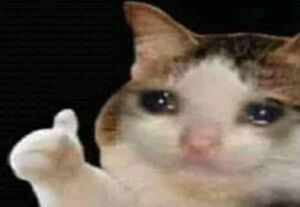

In [78]:
from PIL import Image
myimage = Image.open('/content/drive/My Drive/crying.jpg')  
myimage

**Бонус. (0.1 балла).**

При сдаче проверяющий запустит следующую клетку один раз. Если она даст положительный результат, вы получите 0.1 бонусных балла. Если она даст отрицательный результат, вы получите -0.1 бонусных балла. Если вы получите ровно 0, то мы посчитаем вас невероятно везучим человеком и в качестве поощрения зачтем теорминимум на коллоквиуме. 

Если вы хотите отказаться от сдачи данного задания, допишите "хочу" после двоеточия: `your text here`

Ниже вы можете попрактиковаться и оценить ваши силы (изменять код ячейки запрещается!)

In [72]:
import numpy as np

np.random.randn()

0.5517168213571512